# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from boruta import BorutaPy
import xgboost as xgb

## 0.1. Funções de Ajuda

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold+1)) :
        
        if verbose:
            print(f'\nKFold Number: {k}')
        
        # statart and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance og each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
            'Model Name': model_name,
            'MAR CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
            'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
            'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
        }, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse
                        }, index=[0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 7]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Carregando Dados

In [21]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_sales_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df_family_expenses_raw = pd.read_excel('data/pordata.xlsx', sheet_name='Quadro_Formatado')

In [22]:
df_family_expenses_raw = pd.read_excel('data/pordata.xlsx', sheet_name='Quadro_Formatado')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [23]:
df1 = df_sales_raw.copy()

In [24]:
df1_aux = df_family_expenses_raw.copy()

## 1.1 Renomeando Colunas

In [25]:
cols_new = [ 'store',
             'day_of_week',
             'date',
             'sales',
             'customers',
             'open',
             'promo',
             'state_holiday',
             'school_holiday',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'promo_interval'
           ]

#renomear
df1.columns = cols_new

In [26]:
# formatando dataset pra melhor visualização dos dados
anos = df1_aux['Anos'].drop_duplicates()
paises = df1_aux.columns.drop(['Anos','Tipo de bens e serviços'])

colunas = ['total', 
           'produtos_alimentares_bebida_nao_alcoolica', 
           'bebidas_alcoolicas_tabaco_narcoticos', 
           'vestuario_calcado', 
           'habitacao_agua_eletricidade_gas_outros_combustiveis', 
           'acessorios_lar_equipamento_doméstico_manutencao', 
           'saude', 'transportes', 
           'comunicacoes', 
           'lazer_recreacao_cultura', 
           'educacao', 
           'restaurantes_hoteis', 
           'bens_servicos_diversos']
colunas.insert(0,'ano')
colunas.insert(1,'pais')
df_family_expenses_format = pd.DataFrame(columns=colunas)

for ano in anos:
    for pais in paises:
        aux = df1_aux[pais][df1_aux['Anos'] == ano].T.values.tolist()
        aux.insert(0, ano)
        aux.insert(1, pais)
        df_family_expenses_format.loc[len(df_family_expenses_format)] = aux

df1_aux = df_family_expenses_format

## 1.2 Dimensões dos Dados

In [14]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


In [619]:
print('Number of Rows: {}'.format(df1_aux.shape[0]))
print('Number of Cols: {}'.format(df1_aux.shape[1]))

Number of Rows: 374
Number of Cols: 15


## 1.3 Tipo dos Dados

In [27]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [19]:
df1_aux.dtypes

ano                                                      int64
pais                                                    object
total                                                  float64
produtos_alimentares_bebida_nao_alcoolica              float64
bebidas_alcoolicas_tabaco_narcoticos                   float64
vestuario_calcado                                      float64
habitacao_agua_eletricidade_gas_outros_combustiveis    float64
acessorios_lar_equipamento_doméstico_manutencao        float64
saude                                                  float64
transportes                                            float64
comunicacoes                                           float64
lazer_recreacao_cultura                                float64
educacao                                               float64
restaurantes_hoteis                                    float64
bens_servicos_diversos                                 float64
dtype: object

## 1.4 Verificando NA

In [622]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [623]:
df1_aux.isna().sum()

ano                                                    0
pais                                                   0
total                                                  0
produtos_alimentares_bebida_nao_alcoolica              0
bebidas_alcoolicas_tabaco_narcoticos                   0
vestuario_calcado                                      0
habitacao_agua_eletricidade_gas_outros_combustiveis    0
acessorios_lar_equipamento_doméstico_manutencao        0
saude                                                  0
transportes                                            0
comunicacoes                                           0
lazer_recreacao_cultura                                0
educacao                                               0
restaurantes_hoteis                                    0
bens_servicos_diversos                                 0
dtype: int64

## 1.5 Preencher NA

In [28]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
df1['promo_interval'].fillna(0, inplace=True)

In [626]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6 Alterando Tipo de Dados

In [627]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [29]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Estatística Descritiva

In [30]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Atributos Numéricos

In [631]:
# Tendência Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std (desvio padrão), min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenação
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['atributos','min','max','range','mean','median','std','skew','kurtosis']

In [24]:
m

,atributos,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot: xlabel='competition_distance', ylabel='Count'>

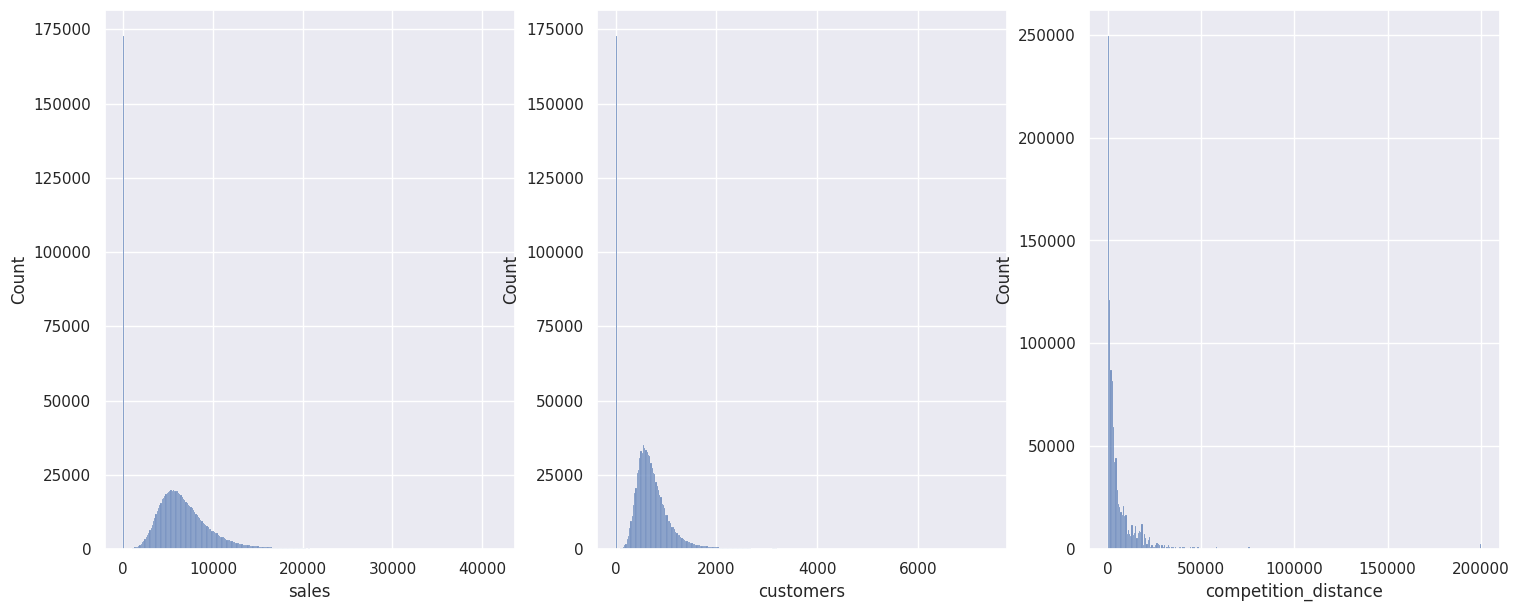

In [633]:
plt.subplot(1,3,1)
sns.histplot(df1['sales'], bins=300)

plt.subplot(1,3,2)
sns.histplot(df1['customers'], bins=300)

plt.subplot(1,3,3)
sns.histplot(df1['competition_distance'], bins=300)

### 1.7.2 Atributos Categóricos

In [634]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

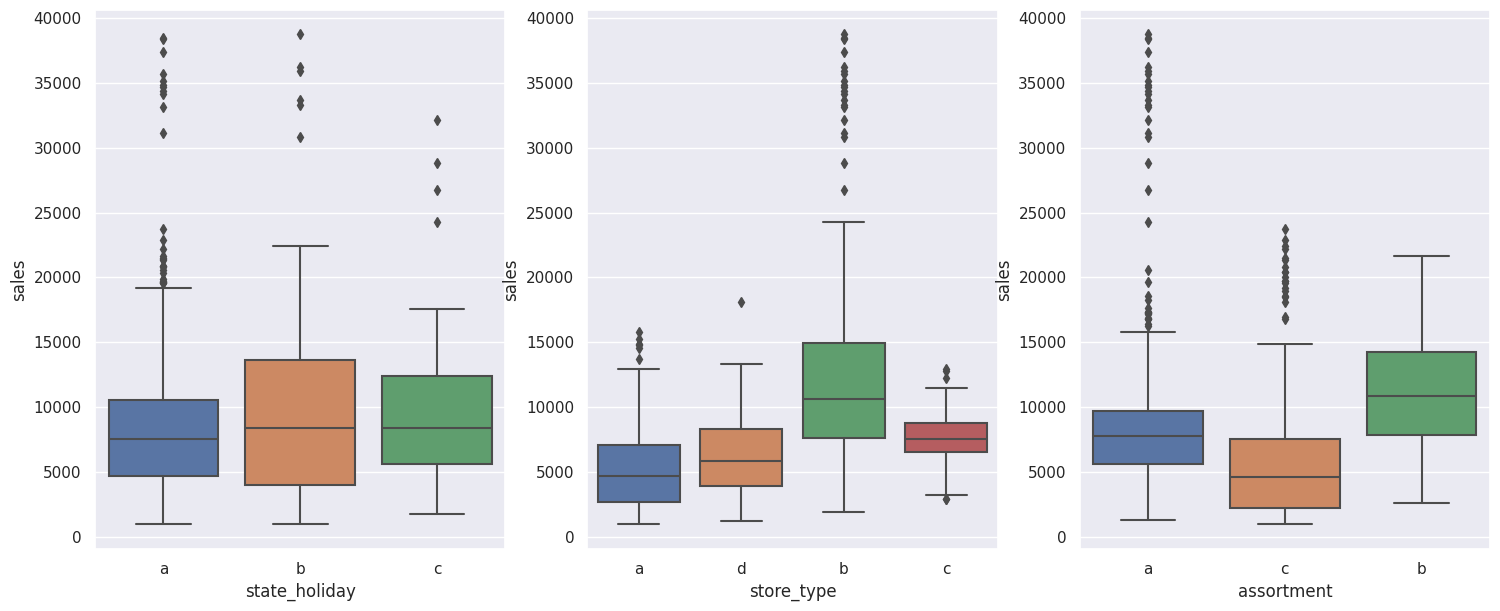

In [635]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [31]:
df2 = df1.copy()

## 2.1 Feature Engineering

In [32]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extend')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# is promo
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['date'].dt.month.map(month_map)

df2['is_promo'] = df2[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [639]:
df2.sample(5).T

,238784,310791,416599,743049,524612
store,641,656,375,130,233
day_of_week,1,1,1,2,2
date,2014-12-29 00:00:00,2014-10-13 00:00:00,2014-06-23 00:00:00,2013-09-03 00:00:00,2014-03-18 00:00:00
sales,4775,2645,6601,4146,10120
customers,452,351,603,517,1134
open,1,1,1,1,1
promo,0,0,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,0,0,0,0
store_type,a,d,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [33]:
df3 = df2.copy()
df3_aux = df1_aux.copy()

## 3.1 Filtragem das Linhas

In [34]:
# vendas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] # open: loja fechada não têm vendas / sales: loja sem vendas

# consumo por familia
df3_aux = df3_aux.query('ano in (2013,2014,2015) and \
                         pais in (\'DE - Alemanha\', \
                                  \'PL - Polónia\', \
                                  \'HU - Hungria\', \
                                  \'CZ - República Checa\', \
                                  \'ES - Espanha\')'
                       )

## 3.2 Seleção das Colunas

In [35]:
# vendas
cols_drop = ['customers','open','promo_interval', 'month_map'] # customers: no momento da predição, não saberemos qual a quantidade de clientes
df3 = df3.drop(cols_drop, axis=1)

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS - EDA

In [36]:
df4 = df3.copy()
df4_aux = df3_aux.copy()

In [37]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Criação das Hipóteses

**H1.**		Lojas com maior variedade deveriam vender mais.

**H2.**		Lojas com concorrentes mais próximos deveriam vender menos.

**H3.**		Lojas com concorrentes há mais tempo deveriam vender mais.

**H4.**		Lojas com promoções ativas por mais tempo deveriam vender mais.

**H5.**		Lojas com mais promoções consecutivas deveriam vender mais.

**H6.**		Lojas abertas durante o feriado de Natal deveriam vender mais.

**H7.**		Lojas deveriam vender mais ao longo dos anos.

**H8.**		Lojas deveriam vender mais no segundo semestre do ano.

**H9.**		Lojas deveriam vender menos aos finais de semana.

**H10.**	Lojas deveriam vender menos durante os feriados escolares.

**H11.**	Lojas deveriam vender mais quando o consumo total nos países aumenta.

**H12.**	Lojas deveriam vender mais quando o consumo em saúde nos países aumenta.

## 4.2 Análise Univariada

### 4.2.1 Variável Resposta

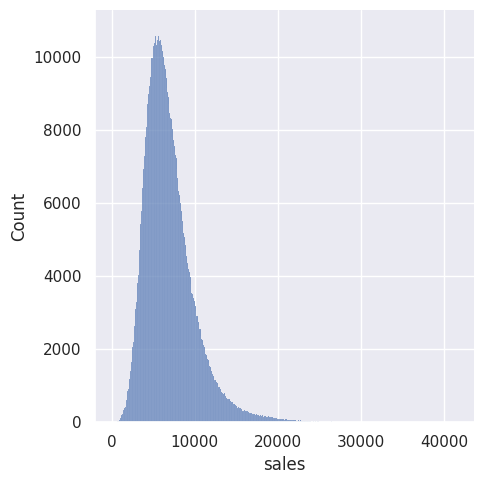

In [645]:
sns.displot(df4['sales'])

### 4.2.2 Variáveis Numéricas

In [646]:
df3_aux.dtypes

ano                                                      int64
pais                                                    object
total                                                  float64
produtos_alimentares_bebida_nao_alcoolica              float64
bebidas_alcoolicas_tabaco_narcoticos                   float64
vestuario_calcado                                      float64
habitacao_agua_eletricidade_gas_outros_combustiveis    float64
acessorios_lar_equipamento_doméstico_manutencao        float64
saude                                                  float64
transportes                                            float64
comunicacoes                                           float64
lazer_recreacao_cultura                                float64
educacao                                               float64
restaurantes_hoteis                                    float64
bens_servicos_diversos                                 float64
dtype: object

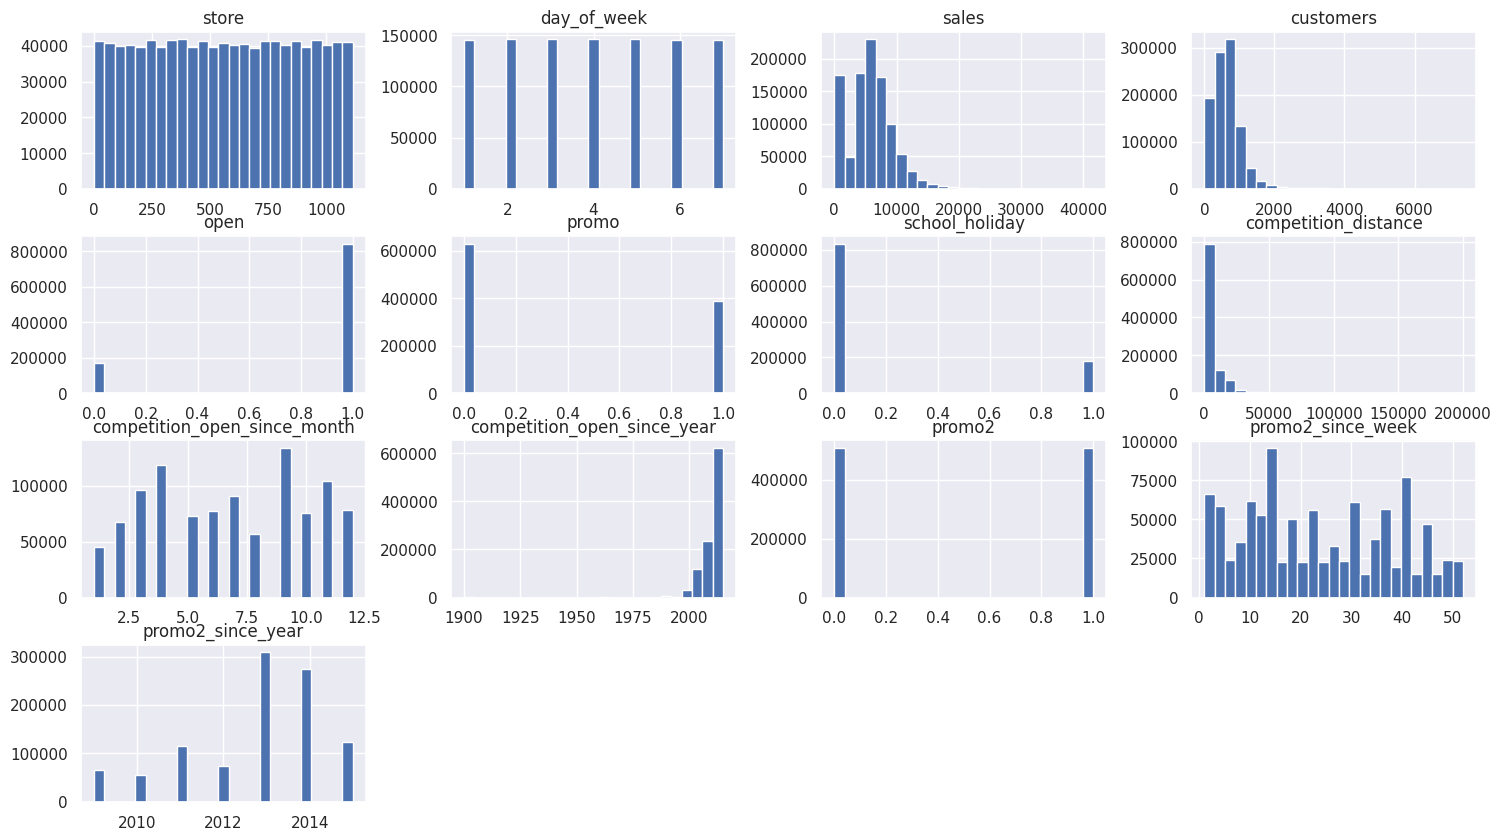

In [715]:
num_attributes.hist(figsize=(18, 10), bins=25);

### 4.2.3 Variáveis Categóricas

In [664]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [665]:
df4['assortment'].drop_duplicates()

0       basic
3      extend
258     extra
Name: assortment, dtype: object

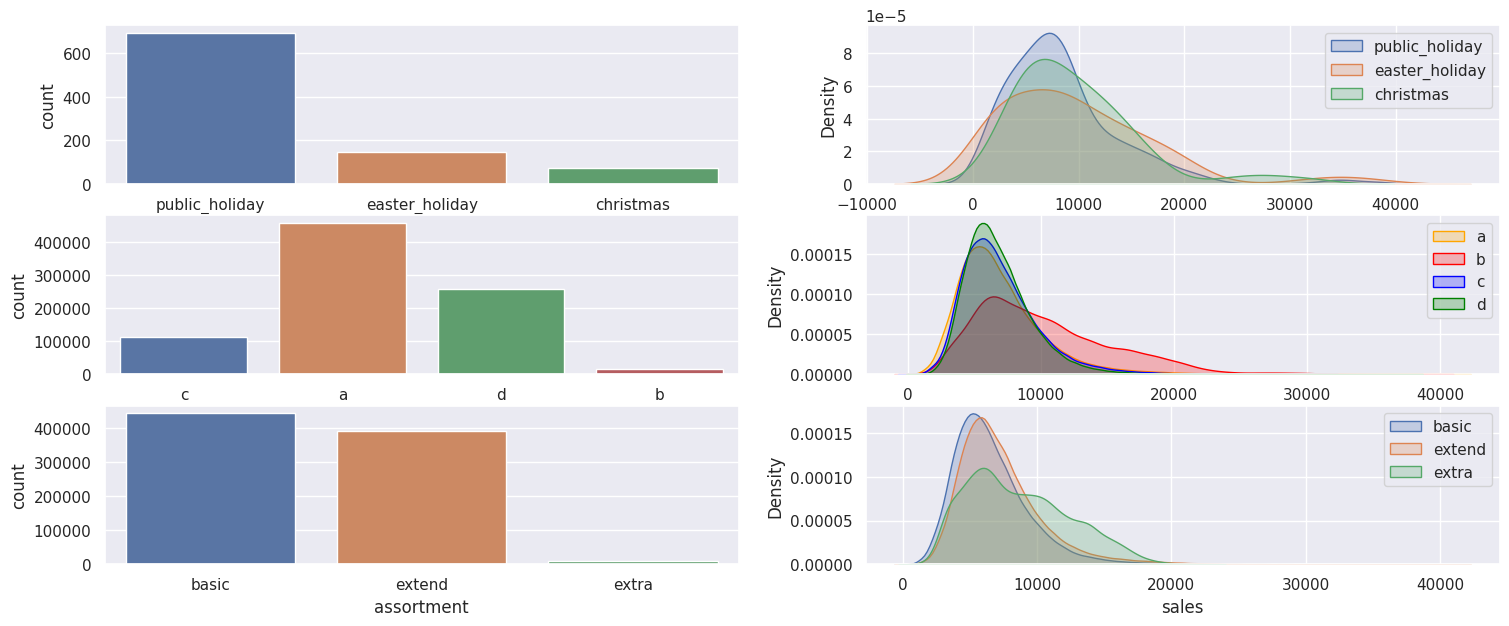

In [716]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill = True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', color='orange', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', color='red', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', color='blue', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', color='green', fill = True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill = True)
plt.legend()

## 4.3 Análise Bivariada

### **H1.** Lojas com maior variedade deveriam vender mais.
**FALSE** Lojas com MAIOR VARIEDADE vendem MENOS - RELEVÂNCIA BAIXA

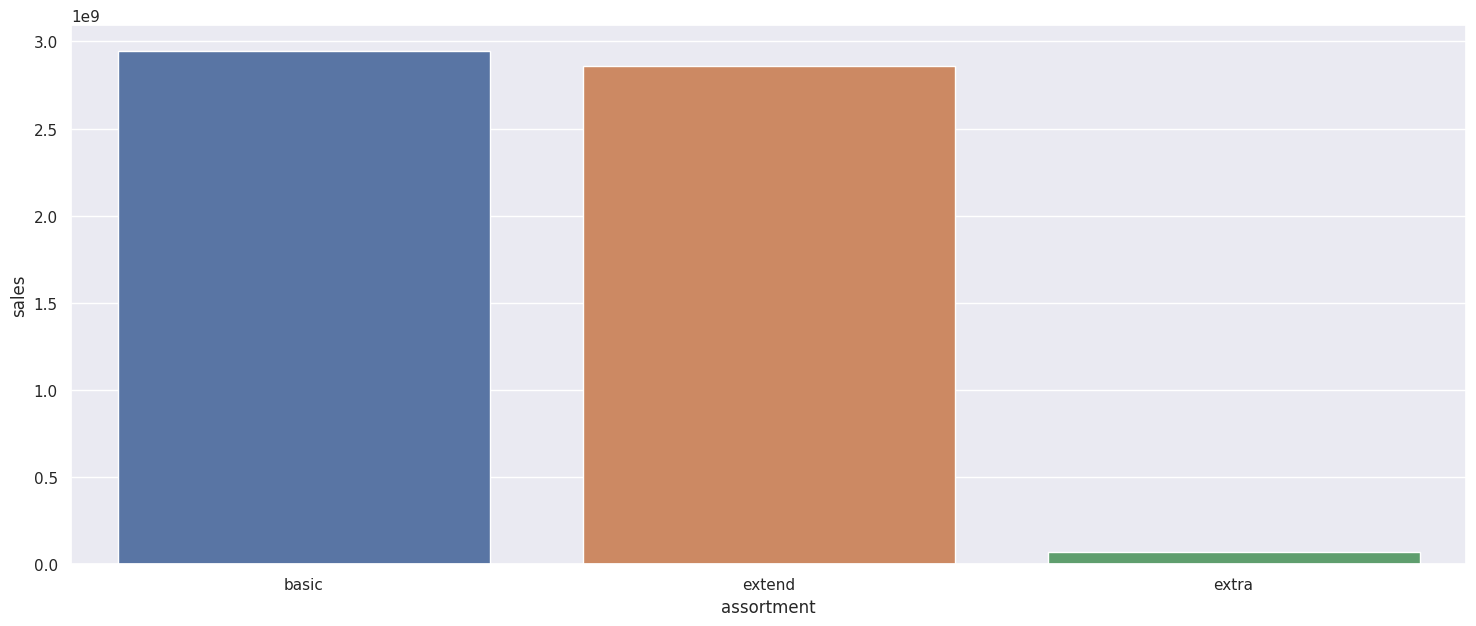

In [667]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

<AxesSubplot: xlabel='year_week'>

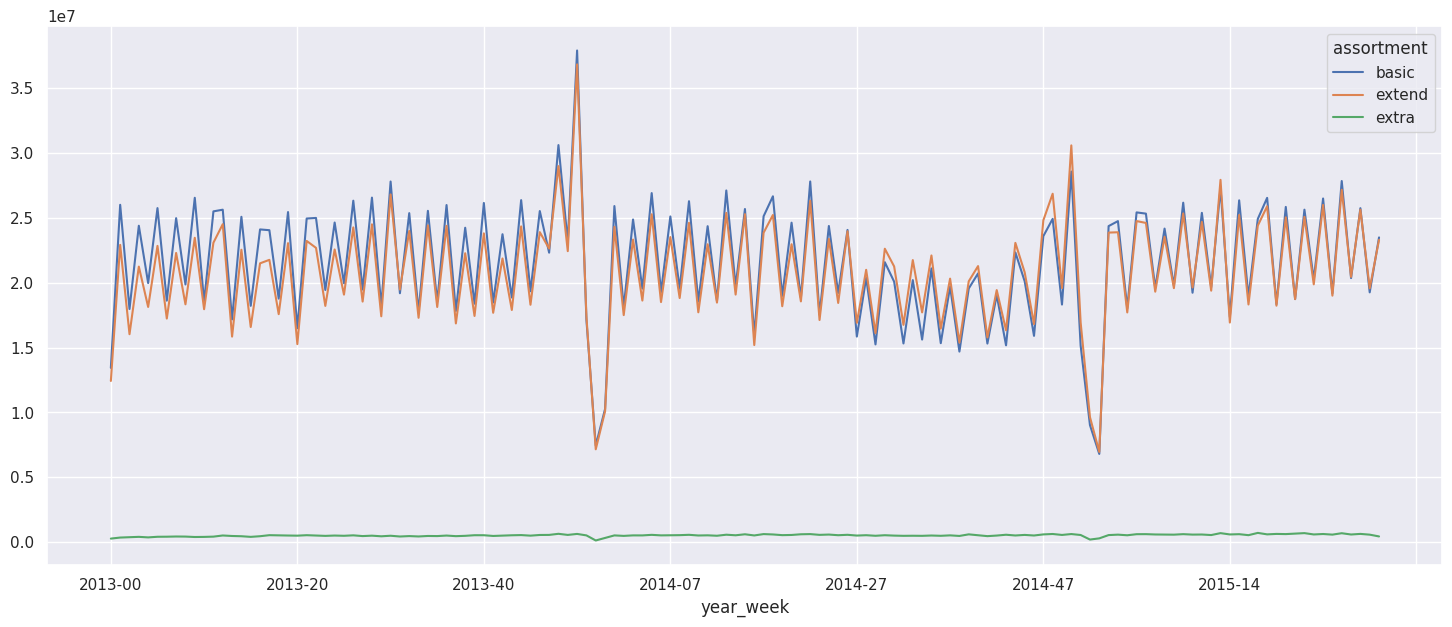

In [668]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

<AxesSubplot: xlabel='year_week'>

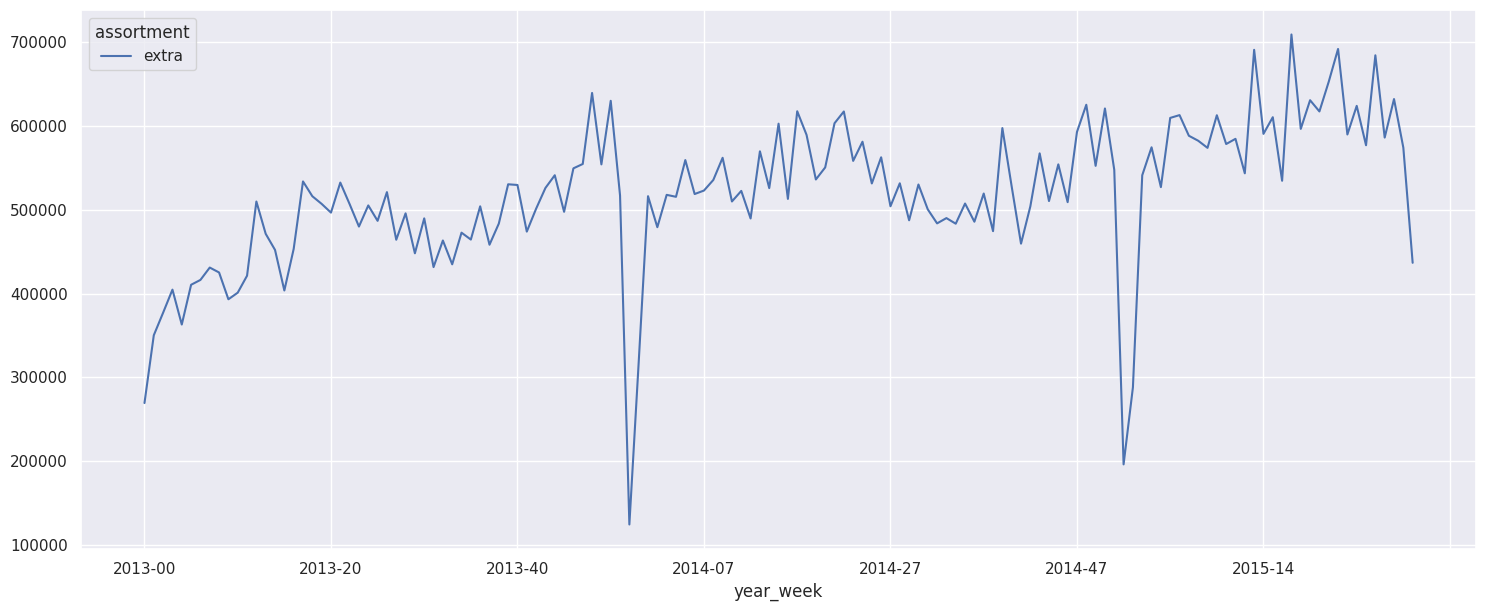

In [669]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

In [670]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **H2.** Lojas com concorrentes mais próximos deveriam vender menos.
**FALSE** Lojas com concorrentes MAIS PRÓXIMOS vendem MAIS - RELEVÂNCIA MÉDIA

/tmp/ipykernel_5223/2792119870.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(), annot=True);


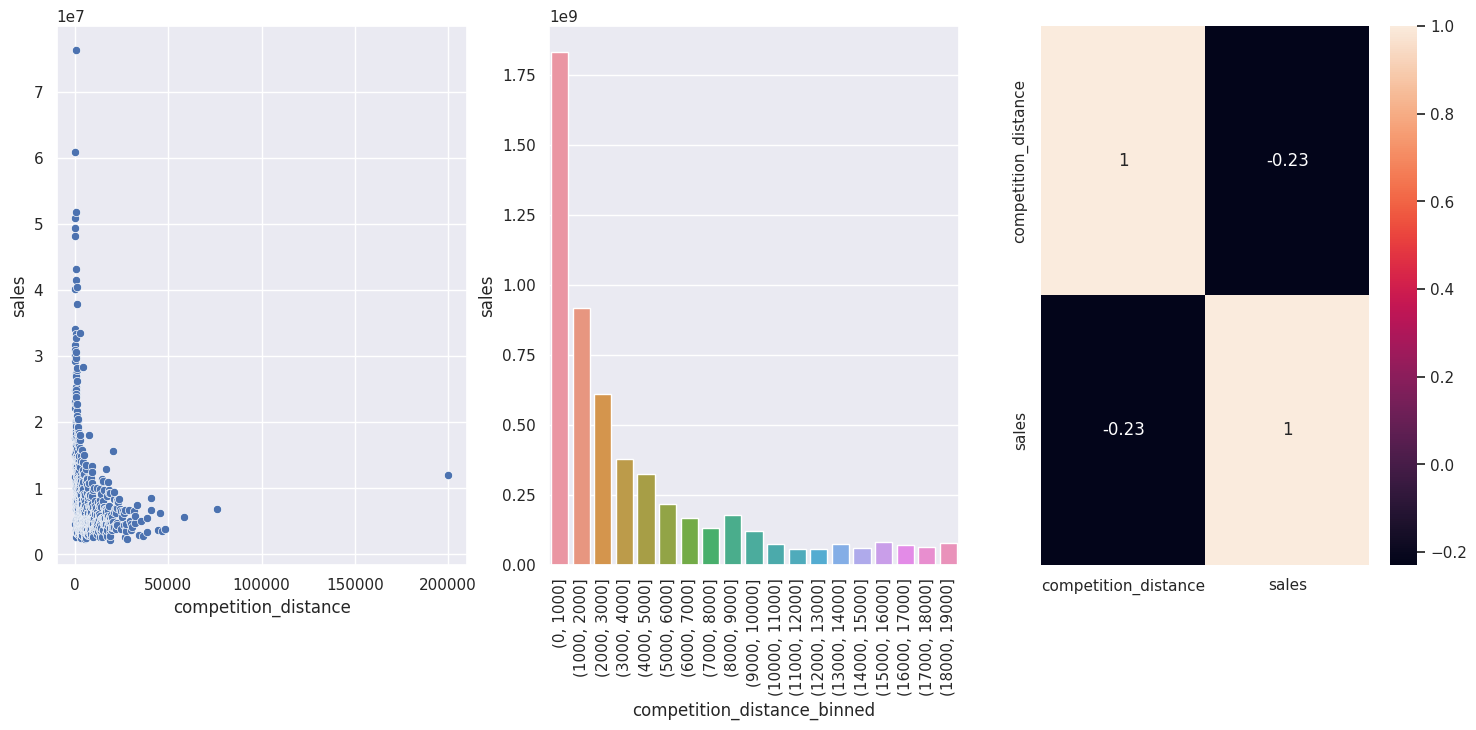

In [719]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### **H3.** Lojas com concorrentes há mais tempo deveriam vender mais.
**FALSE** Lojas com concorrentes HÁ MAIS TEMPO vendem MENOS - RELEVÂNCIA MÉDIA

<AxesSubplot: >

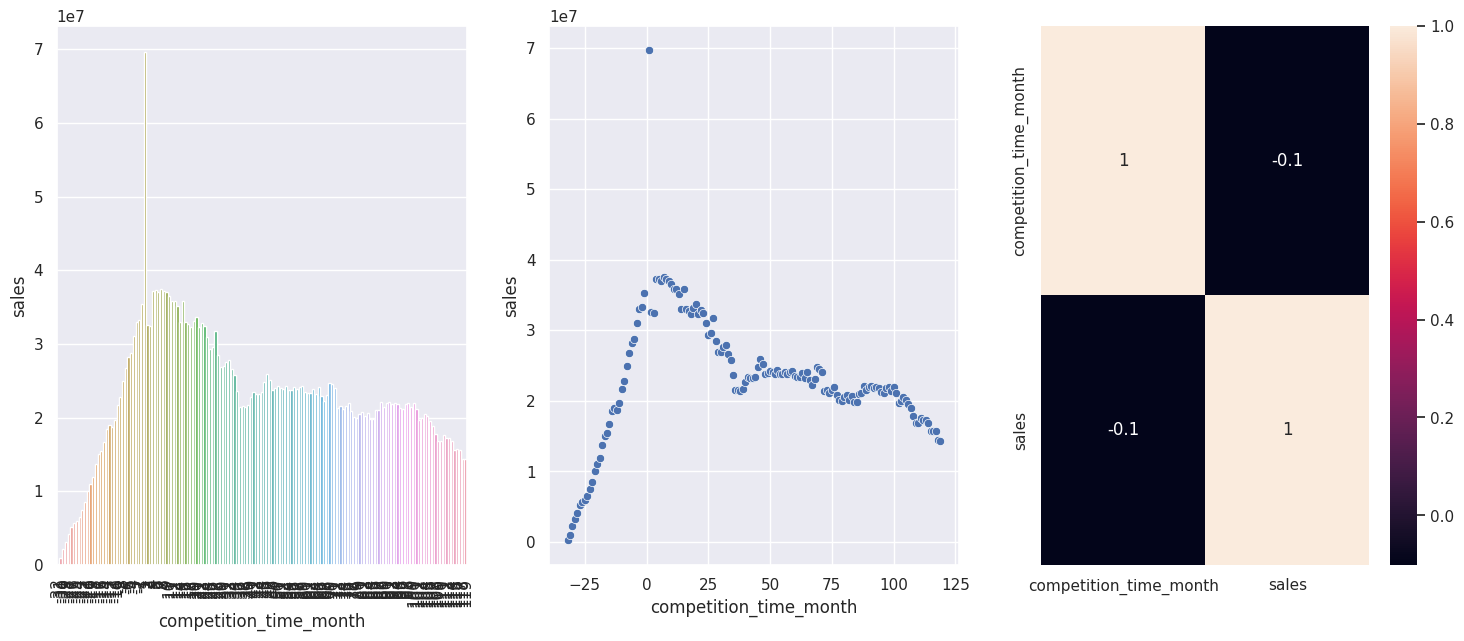

In [672]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.scatterplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSE** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo período de promoção - RELEVÂNCIA BAIXA

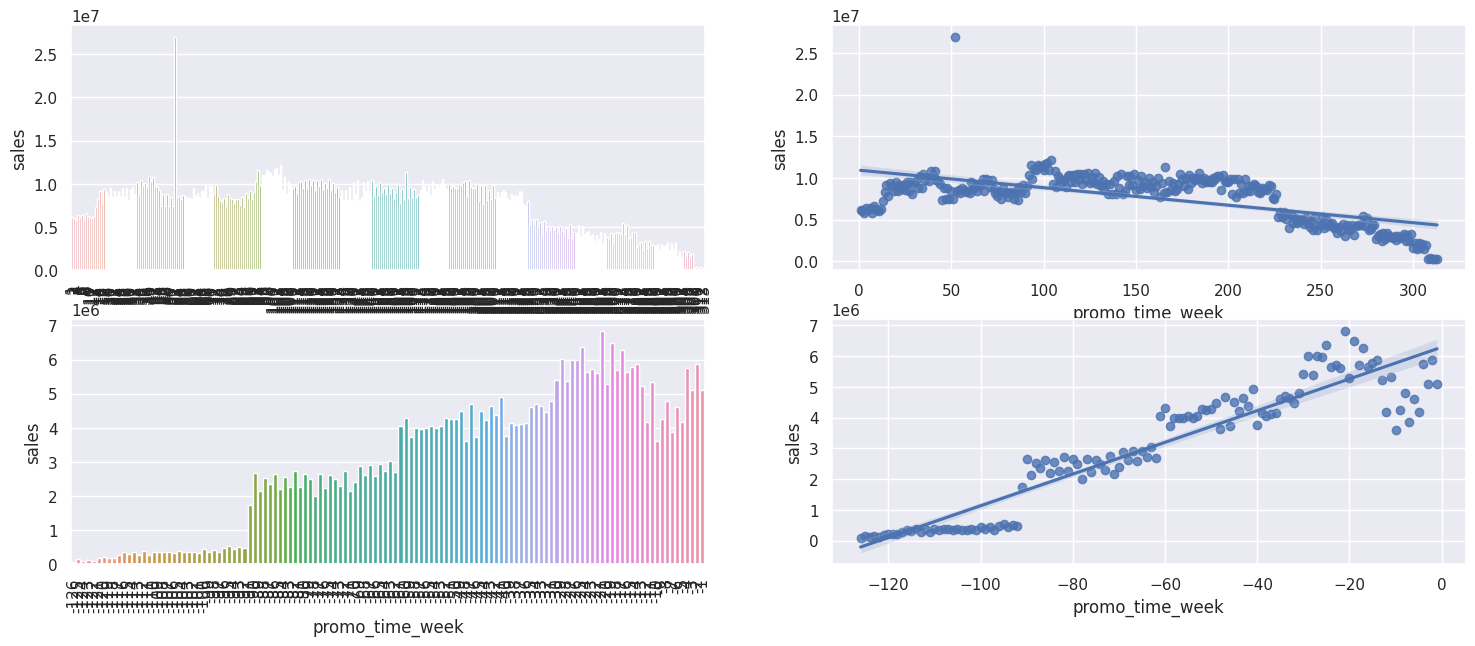

In [673]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2, 2, 3)
aux3= aux1[aux1['promo_time_week'] <0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

<AxesSubplot: >

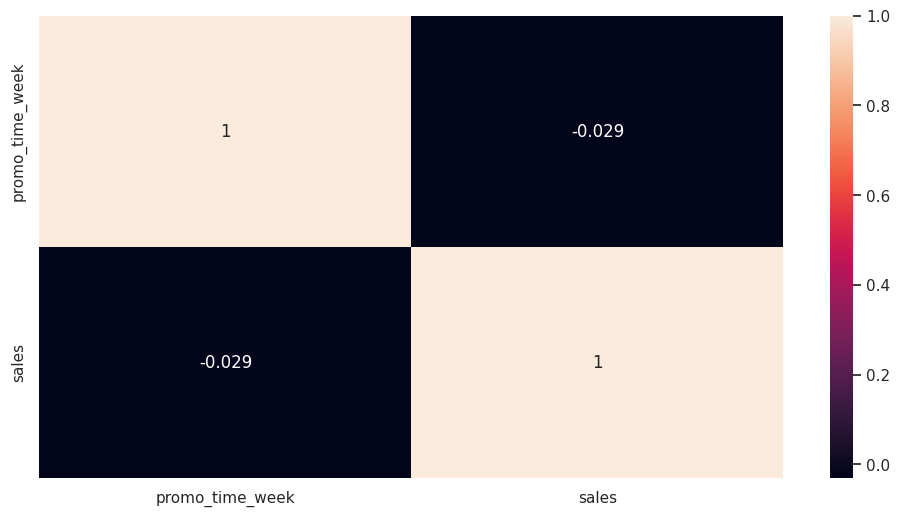

In [57]:
sns.heatmap(aux1.corr(), annot=True)

### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSE** Lojas com PROMOÇÕES CONSECUTIVAS vendem MENOS - RELEVÂNCIA BAIXA

In [674]:
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(by=['sales'], ascending=False).reset_index()

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


### **H6.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSE** Lojas ABERTAS DURANTE O FERIADO DE NATAL vendem MENOS - RELEVÂNCIA MÉDIA

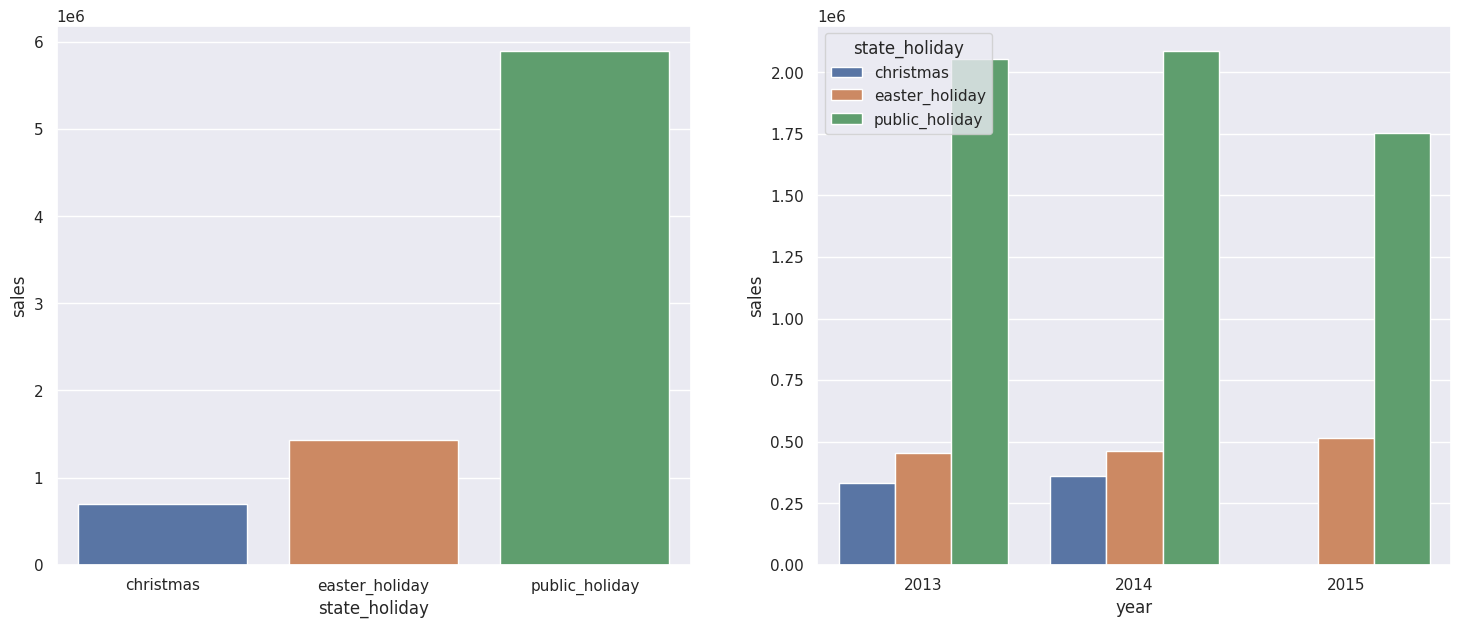

In [675]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSE** Lojas vendem MENOS AO LONGO DO ANO - RELEVÂNCIA ALTA

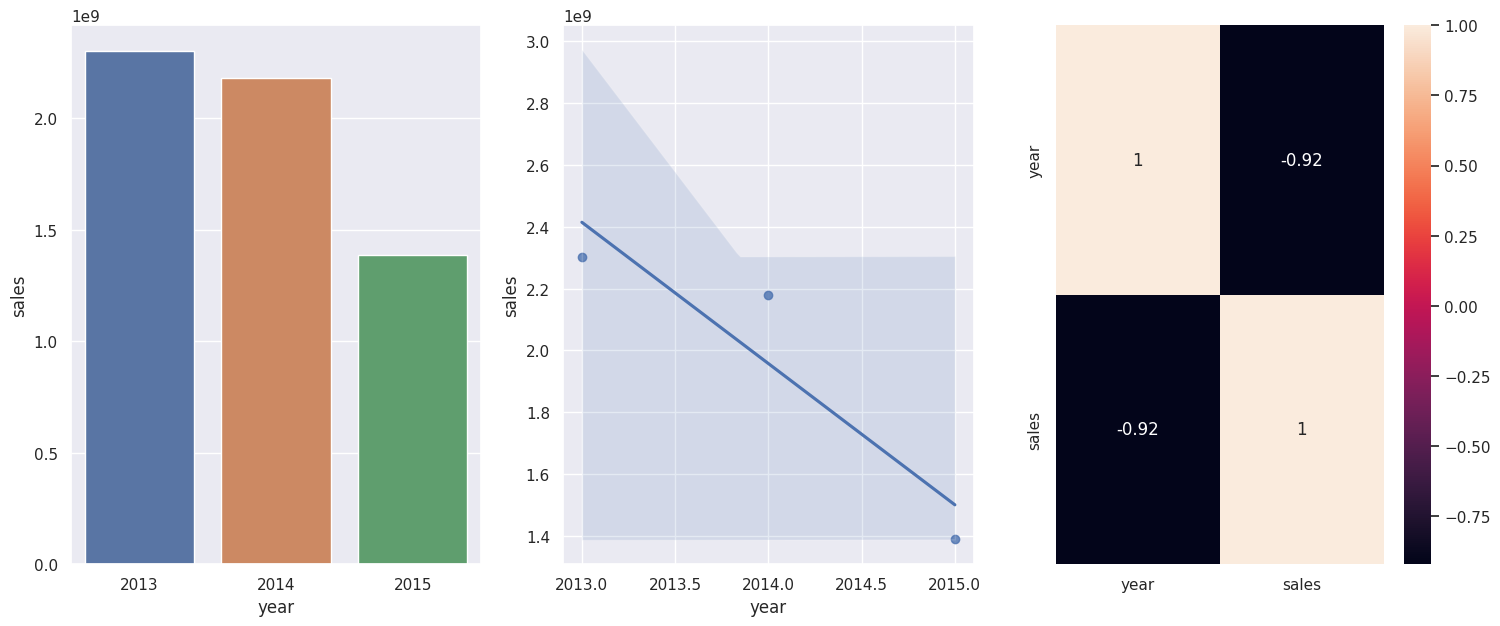

In [676]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** Lojas vendem MENOS NO SEGUNDO SEMESTRE DO ANO - RELEVÂNCIA ALTA

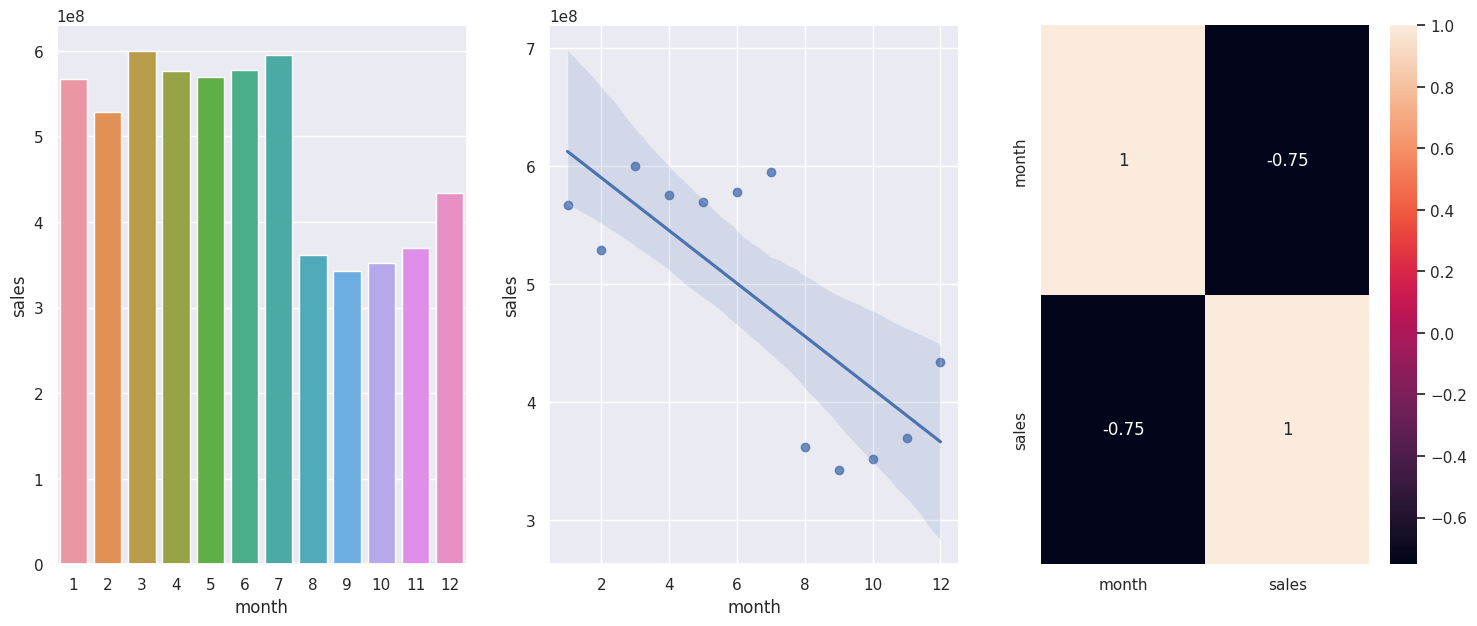

In [677]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### **H9.** Lojas deveriam vender menos aos finais de semana.
**TRUE** Lojas vendem MENOS AOS FINAIS DE SEMANA - RELEVÂNCIA ALTA

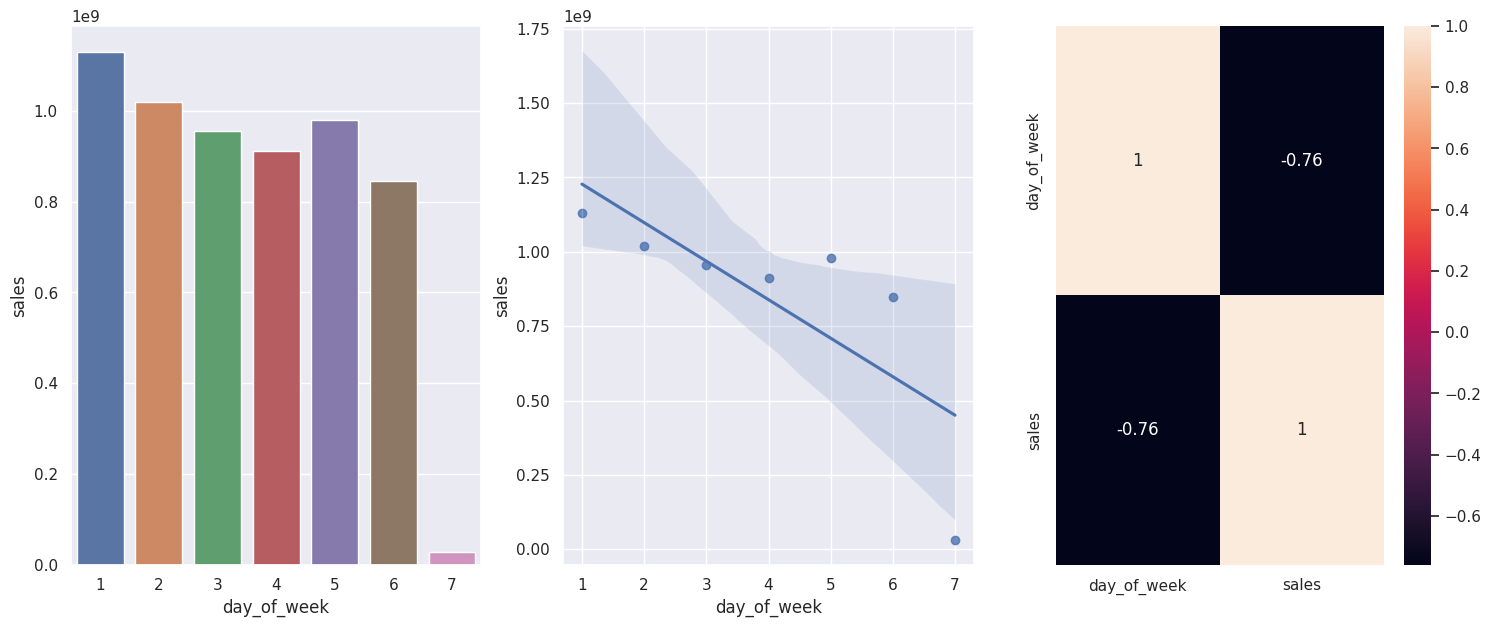

In [678]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### **H10.** Lojas deveriam vender menos durante os feriados escolares.
**TRUE** Lojas vendem MENOS DURANTE OS FERIADOS ESCOLARES, EXCETO OS MESES DE JULHO E AGOSTO - RELEVÂNCIA BAIXA

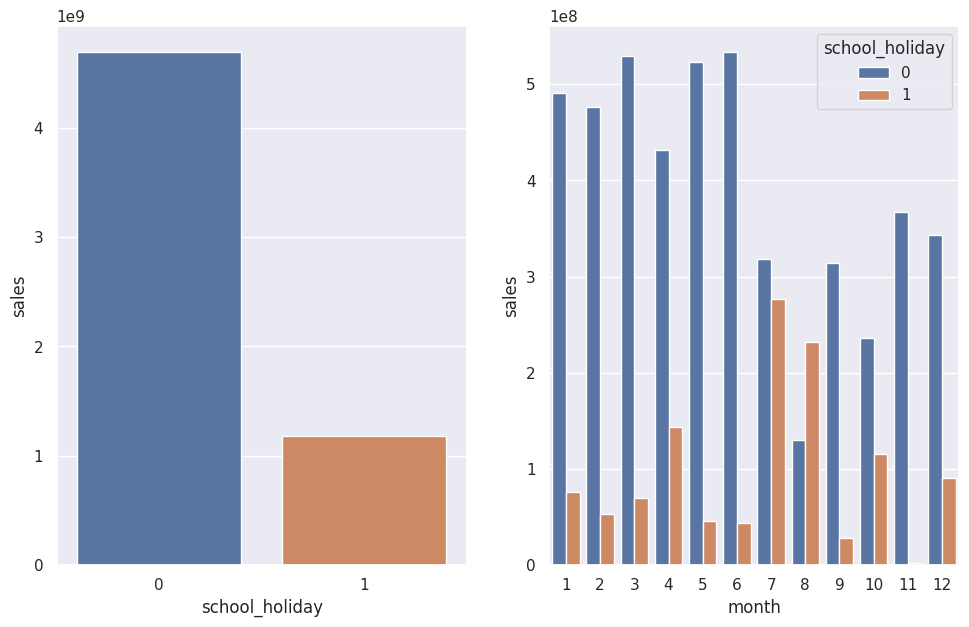

In [679]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(1, 3, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### **H11.** Lojas deveriam vender mais quando o consumo total nos países aumenta.
**FALSE** Lojas vendem MENOS QUANDO O CONSUMO TOTAL AUMENTA - RELEVÂNCIA ALTA

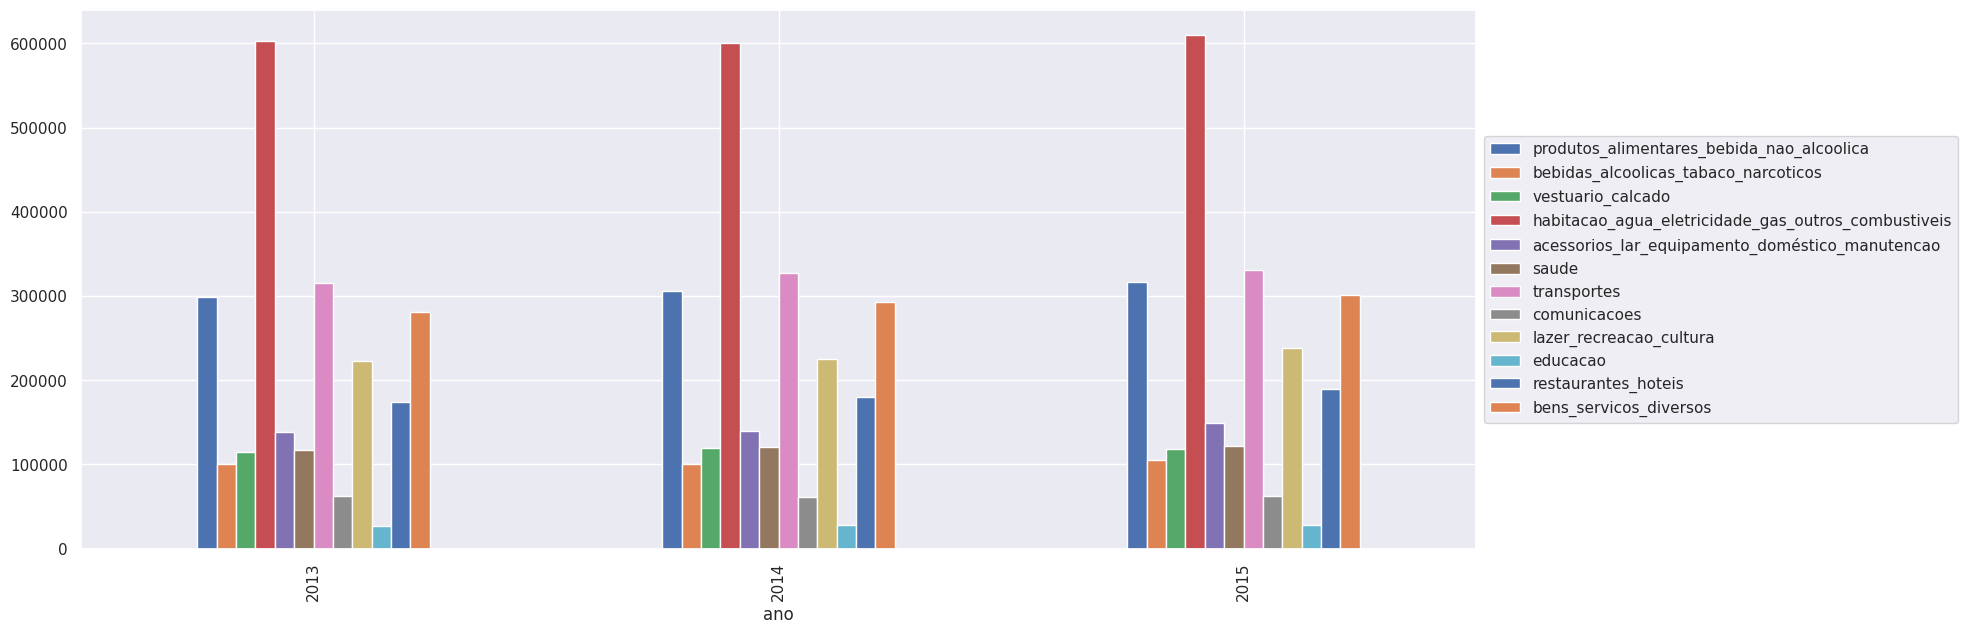

In [581]:
# consumo por tipo e por ano
cols_cons = df4_aux.columns.drop(['total','ano','pais']).to_list()
aux_1 = df4_aux.drop(['total','pais'], axis=1).groupby('ano').sum().reset_index()

aux_1.plot('ano', cols_cons, kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

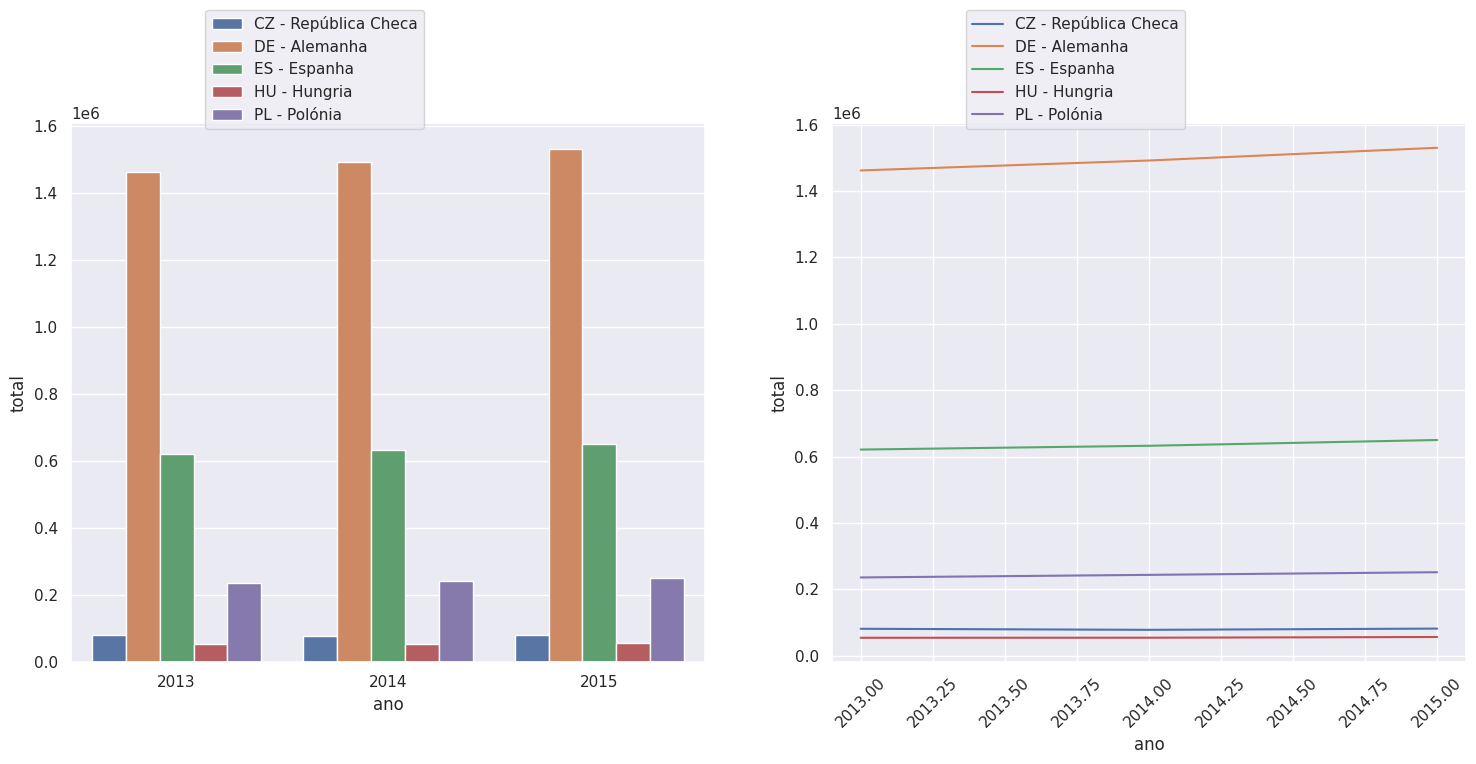

In [544]:
# consumo total por país
aux_2 = df4_aux[['ano', 'pais', 'total']].groupby(['ano','pais']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='ano', y='total', hue='pais', data=aux_2)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))

plt.subplot(1,2,2)
sns.lineplot(x='ano', y='total', hue='pais', data=aux_2)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))
plt.xticks(rotation=45);

In [601]:
# analisando valores dos totais de vendas por ano e consumo total na Alemanha
aux_41 = df4_aux[['ano', 'pais', 'total']].groupby(['ano','total']).sum().reset_index().rename(columns={'pais': 'pais_loja'})

aux_42 = df4[['year','sales']].groupby('year').sum().reset_index().rename(columns={'year': 'ano', 'sales': 'total'})
aux_42['pais_loja'] = 'Rossmann'

aux_4 = pd.concat([aux_41, aux_42])

aux_4.sort_values('total')

,ano,total,pais_loja
0,2013,5.425910e+04,HU - Hungria
5,2014,5.445160e+04,HU - Hungria
10,2015,5.657880e+04,HU - Hungria
6,2014,7.819130e+04,CZ - República Checa
1,2013,8.133330e+04,CZ - República Checa
11,2015,8.190340e+04,CZ - República Checa
2,2013,2.359974e+05,PL - Polónia
7,2014,2.437822e+05,PL - Polónia
12,2015,2.517418e+05,PL - Polónia
3,2013,6.212580e+05,ES - Espanha


In [592]:
aux_4[aux_4['pais_loja']=='Rossmann'].total.max() , aux_4[aux_4['pais_loja']!='Rossmann'].total.max()

(2302876084.0, 1530457.0)

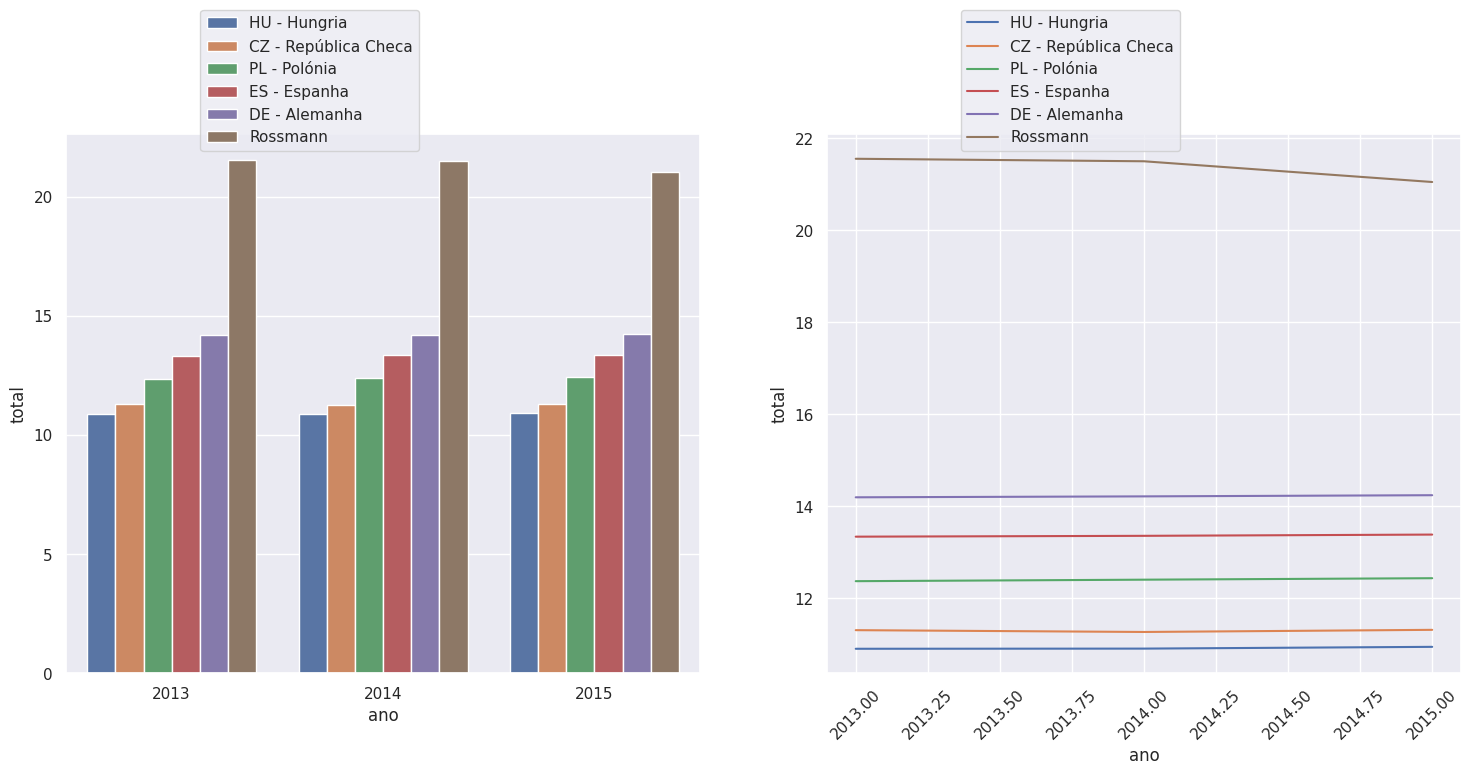

In [602]:
# avaliando total aplicando log devido o range muito alto entre os valores
aux_4['total'] = np.log1p(aux_4['total'])

plt.subplot(1,2,1)
sns.barplot(x='ano', y='total', hue='pais_loja', data=aux_4)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))

plt.subplot(1,2,2)
sns.lineplot(x='ano', y='total', hue='pais_loja', data=aux_4)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))
plt.xticks(rotation=45);

### **H12.** Lojas deveriam vender mais quando o consumo em saúde nos países aumenta.
**FALSE** Lojas vendem MENOS QUANDO O CONSUMO EM SAÚDE AUMENTA - RELEVÂNCIA ALTA

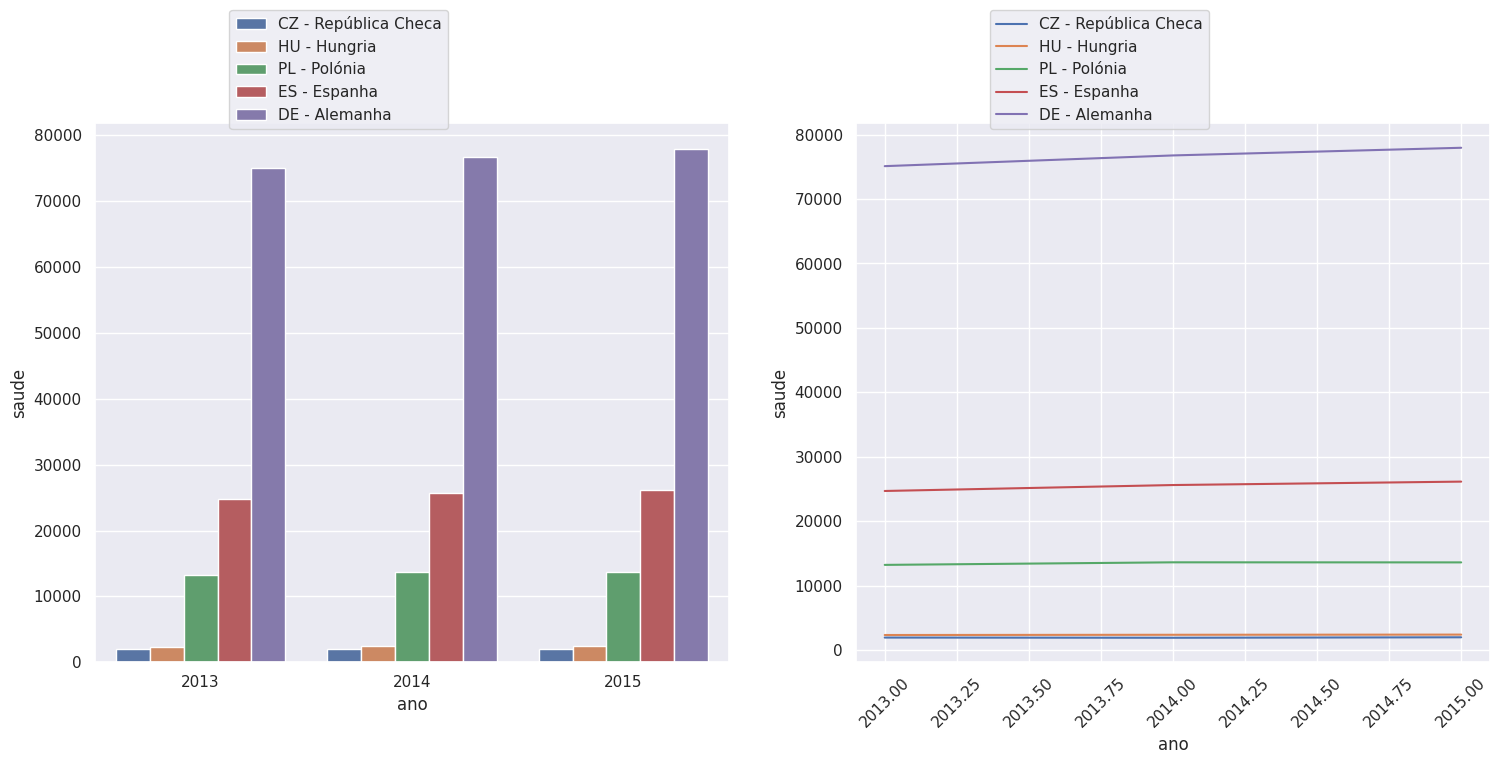

In [545]:
# analisando valores dos totais de vendas por ano e consumo com saude por ano
aux_4 = df4_aux[['ano', 'pais', 'saude']].groupby(['ano','saude']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='ano', y='saude', hue='pais', data=aux_4)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))

plt.subplot(1,2,2)
sns.lineplot(x='ano', y='saude', hue='pais', data=aux_4)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))
plt.xticks(rotation=45);

In [555]:
# analisando valores dos totais de vendas por ano e consumo com saude por pais
aux_41 = df4_aux[['ano', 'pais', 'saude']].groupby(['ano','saude']).sum().reset_index().rename(columns={'pais': 'pais_loja', 'saude': 'total'})

aux_42 = df4[['year','sales']].groupby('year').sum().reset_index().rename(columns={'year': 'ano', 'sales': 'total'})
aux_42['pais_loja'] = 'Rossmann'

aux_4 = pd.concat([aux_41, aux_42])

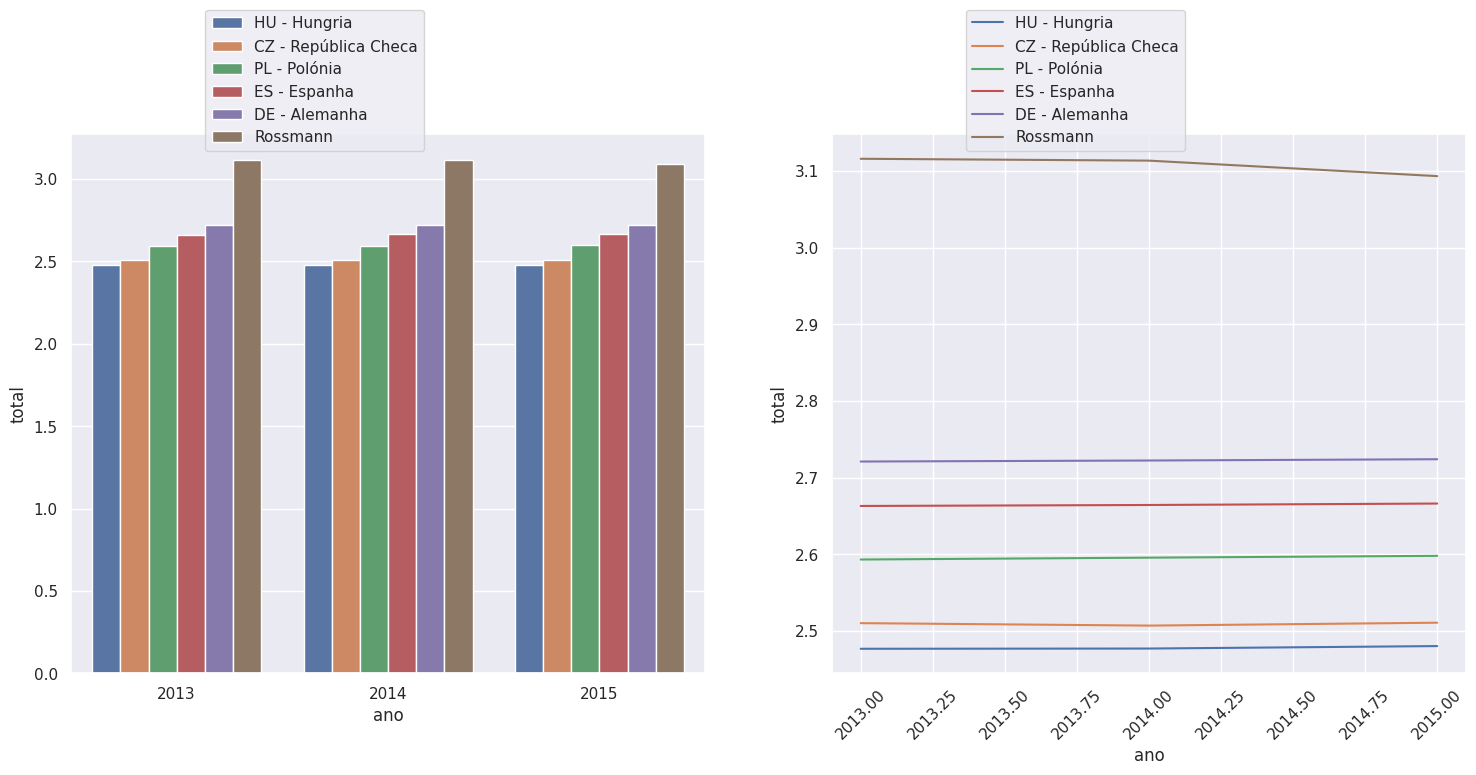

In [600]:
# avaliando total aplicando log devido o range muito alto entre os valores
aux_4['total'] = np.log1p(aux_4['total'])

plt.subplot(1,2,1)
sns.barplot(x='ano', y='total', hue='pais_loja', data=aux_4)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))

plt.subplot(1,2,2)
sns.lineplot(x='ano', y='total', hue='pais_loja', data=aux_4)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.1))
plt.xticks(rotation=45);

### 4.2.1 Resumo das Hipóteses

In [72]:
from tabulate import tabulate

In [541]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Falsa', 'Baixa'],
      ['H6', 'Falsa', 'Media'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Verdadeira', 'Baixa'],
      ['H11', 'Falsa', 'Alta'],
      ['H12', 'Falsa', 'Alta']
     ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Media
H7           Falsa        Alta
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Baixa
H11          Falsa        Alta
H12          Falsa        Alta


# 5.0 PASSO 05 - PREPARAÇÃO DOS DADOS

In [39]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

<AxesSubplot: xlabel='year'>

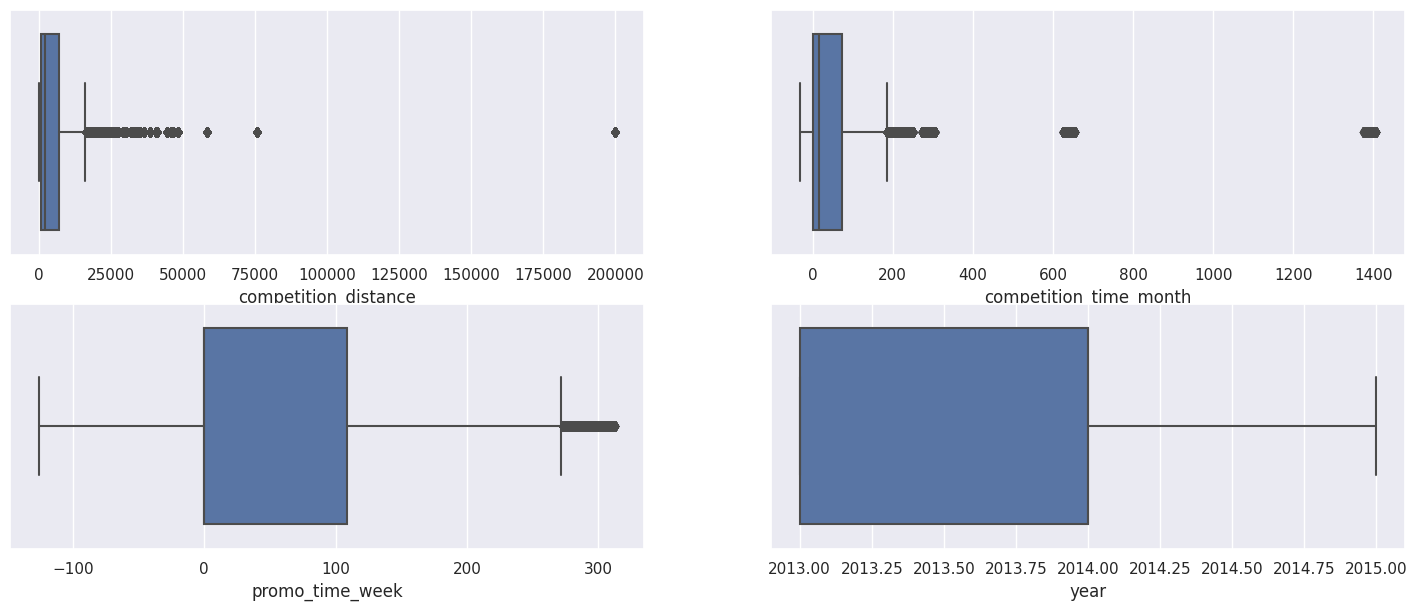

In [40]:
plt.subplot(2, 2, 1)
sns.boxplot(x=df5['competition_distance'])

plt.subplot(2, 2, 2)
sns.boxplot(x=df5['competition_time_month'])

plt.subplot(2, 2, 3)
sns.boxplot(x=df5['promo_time_week'])

plt.subplot(2, 2, 4)
sns.boxplot(x=df5['year'])

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

<AxesSubplot: xlabel='competition_time_month', ylabel='Count'>

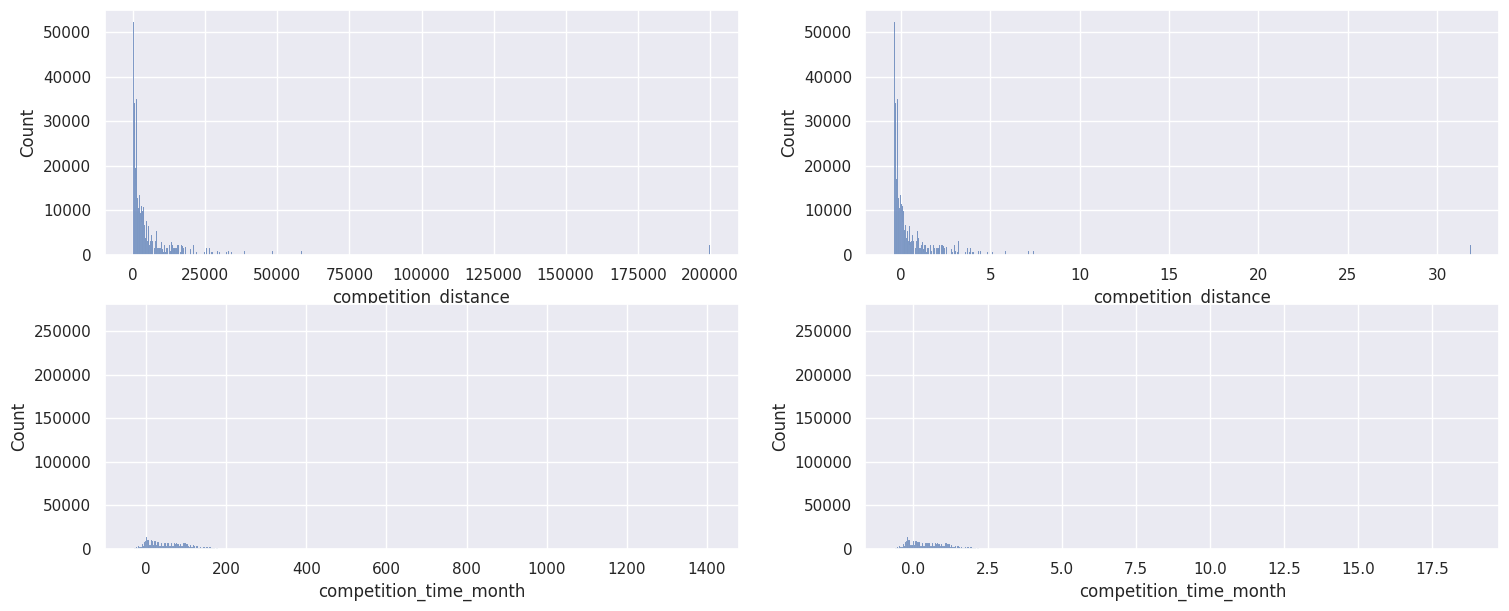

In [49]:
plt.subplot(2, 2, 1)
sns.histplot(df4['competition_distance'])

plt.subplot(2, 2, 2)
sns.histplot(df5['competition_distance'])

plt.subplot(2, 2, 3)
sns.histplot(df4['competition_time_month'])

plt.subplot(2, 2, 4)
sns.histplot(df5['competition_time_month'])

<AxesSubplot: xlabel='year', ylabel='Count'>

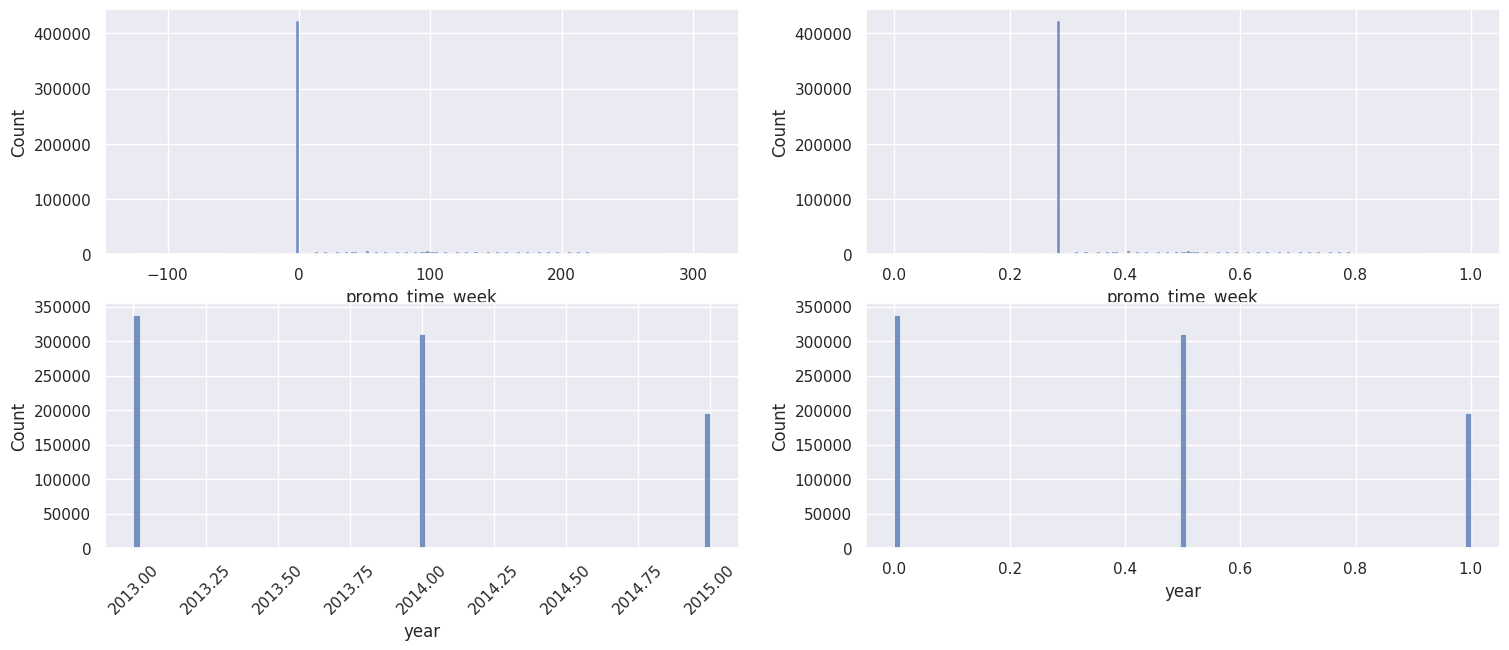

In [47]:
plt.subplot(2, 2, 1)
sns.histplot(df4['promo_time_week'])

plt.subplot(2, 2, 2)
sns.histplot(df5['promo_time_week'])

plt.subplot(2, 2, 3)
sns.histplot(df4['year'])
plt.xticks(rotation=45);

plt.subplot(2, 2, 4)
sns.histplot(df5['year'])

## 5.3 Transformação

### 5.3.1 Encoding

In [688]:
df5['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [689]:
df5['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [690]:
df5['assortment'].drop_duplicates()

0       basic
3      extend
258     extra
Name: assortment, dtype: object

In [691]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extend': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da Variável Resposta

In [692]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot: xlabel='sales', ylabel='Count'>

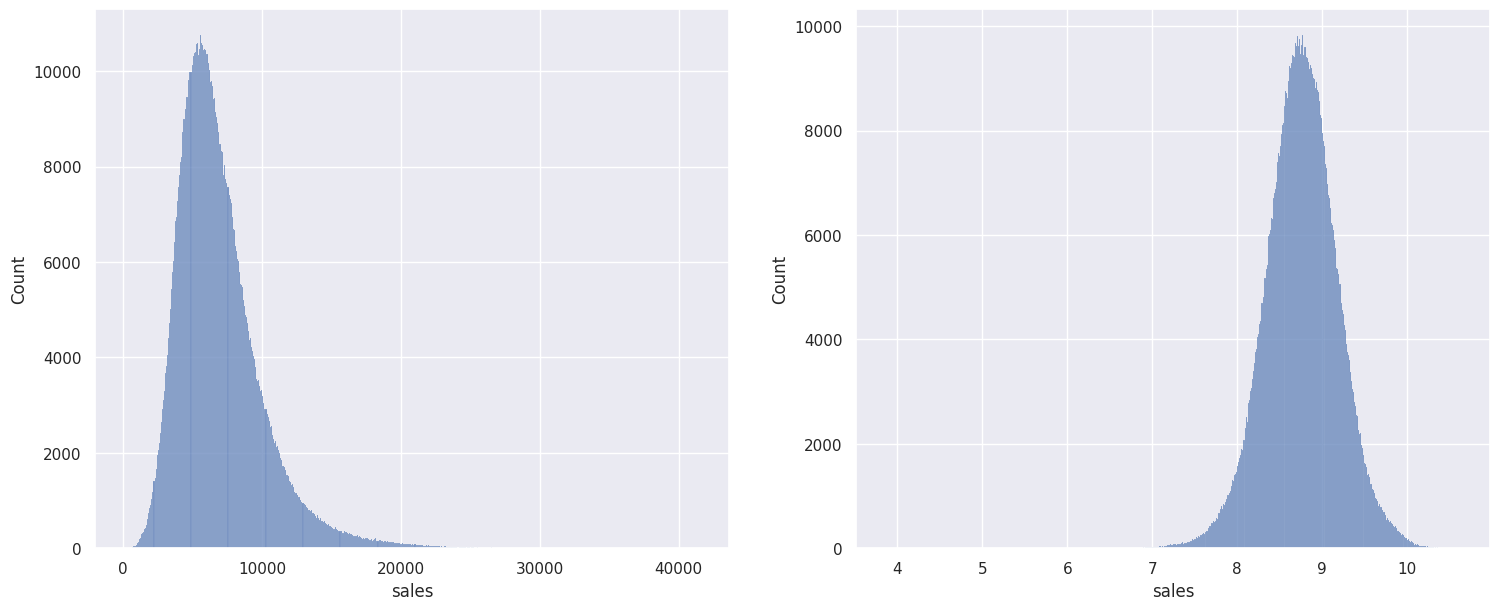

In [693]:
plt.subplot(1, 2, 1)
sns.histplot(df4['sales'])
plt.subplot(1, 2, 2)
sns.histplot(df5['sales'])

### 5.3.3 Transformação de Natureza

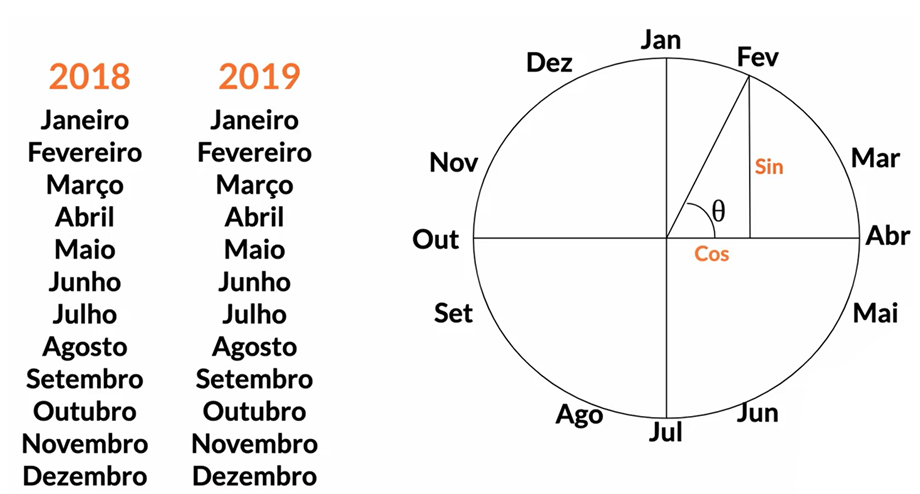

In [721]:
from IPython.display import Image
Image('img/transformação de natureza.PNG')

In [694]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 PASSO 06 - SELEÇÃO DE VARIÁVEIS

In [695]:
df6 = df5.copy();

## 6.1 Separando os Dados em Treino e Teste

In [696]:
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [697]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [698]:
# dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Treinamento - Data Min: {}'. format( X_train['date'].min()))
print('Treinamento - Data Max: {}'. format( X_train['date'].max()))

print('\nTeste - Data Min: {}'. format( X_test['date'].min()))
print('Teste - Data Max: {}'. format( X_test['date'].max()))

Treinamento - Data Min: 2013-01-01 00:00:00
Treinamento - Data Max: 2015-06-18 00:00:00

Teste - Data Min: 2015-06-19 00:00:00
Teste - Data Max: 2015-07-31 00:00:00


## 6.2 Seleção de Variáveis com Boruta

In [67]:
# dataset de treino e teste para o Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [99]:
# definindo RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# treinando Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Melhores Variáves do Boruta

In [146]:
cols_selected = boruta.support_.tolist()

# melhores variáveis
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# variáveis não selecionadas pelo boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [147]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [148]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Seleção de Variáveis Manualmente (evita nova execução do Boruta)

In [699]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# colunas adicionadas novamente
feat_to_add = ['date', 'sales']

# lista final
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 PASSO 07 - MODELANDO MACHINE LEARNING

In [700]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

y_train = X_train['sales']
y_test = X_test['sales']

print('Treinamento - Data Min: {}'. format( X_train['date'].min()))
print('Treinamento - Data Max: {}'. format( X_train['date'].max()))

print('\nTeste - Data Min: {}'. format( X_test['date'].min()))
print('Teste - Data Max: {}'. format( X_test['date'].max()))

# Dados para série temporal
x_training = X_train[cols_selected_boruta_full]

Treinamento - Data Min: 2013-01-01 00:00:00
Treinamento - Data Max: 2015-06-18 00:00:00

Teste - Data Min: 2015-06-19 00:00:00
Teste - Data Max: 2015-07-31 00:00:00


## 7.1 Average Model

In [701]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result                           

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [118]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# predicão
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


In [219]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAR CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


In [222]:
# dataset para análise predição
df_sales_predict_lr = pd.DataFrame()
df_sales_predict_lr['date'] = X_test.date
df_sales_predict_lr['sales'] = y_test
df_sales_predict_lr['preticted_sales'] = list(yhat_lr)

<AxesSubplot: xlabel='date', ylabel='sales'>

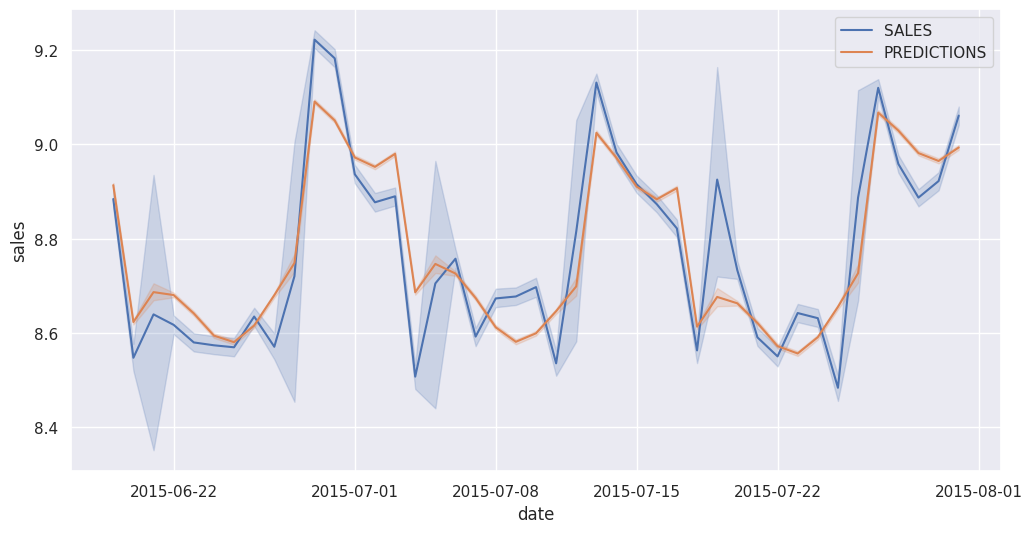

In [125]:
# gráfico predição
sns.lineplot(x='date', y='sales', data=df_sales_predict_lr, label='SALES')
sns.lineplot(x='date', y='preticted_sales', data=df_sales_predict_lr, label='PREDICTIONS')

## 7.3 Random Forest Regressor

In [119]:
# modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# predição
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


In [224]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAR CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


In [221]:
# dataset para análise predição
df_sales_predict_rf = pd.DataFrame()
df_sales_predict_rf['date'] = X_test.date
df_sales_predict_rf['sales'] = y_test
df_sales_predict_rf['preticted_sales'] = list(yhat_rf)

<AxesSubplot: xlabel='date', ylabel='sales'>

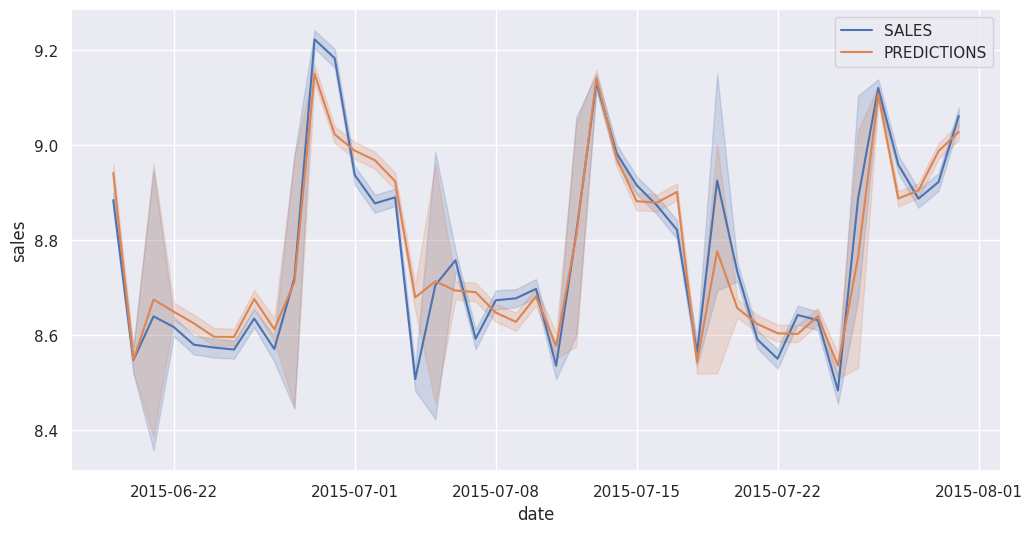

In [89]:
# gráfico predição
sns.lineplot(x='date', y='sales', data=df_sales_predict_rf, label='SALES')
sns.lineplot(x='date', y='preticted_sales', data=df_sales_predict_rf, label='PREDICTIONS')

## 7.4 XGBoost Regressor

In [120]:
# modelo
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# predicão
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958204,0.130309,1238.550842


In [225]:
xgb_result_cv = cross_validation(x_training, 10, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAR CV,MAPE CV,RMSE CV
0,XGBoost Regressor,974.05 +/- 161.1,0.14 +/- 0.02,1387.0 +/- 224.92


In [223]:
# dataset para análise predição
df_sales_predict_xgb = pd.DataFrame()
df_sales_predict_xgb['date'] = X_test.date
df_sales_predict_xgb['sales'] = y_test
df_sales_predict_xgb['preticted_sales'] = list(yhat_xgb)

<AxesSubplot: xlabel='date', ylabel='sales'>

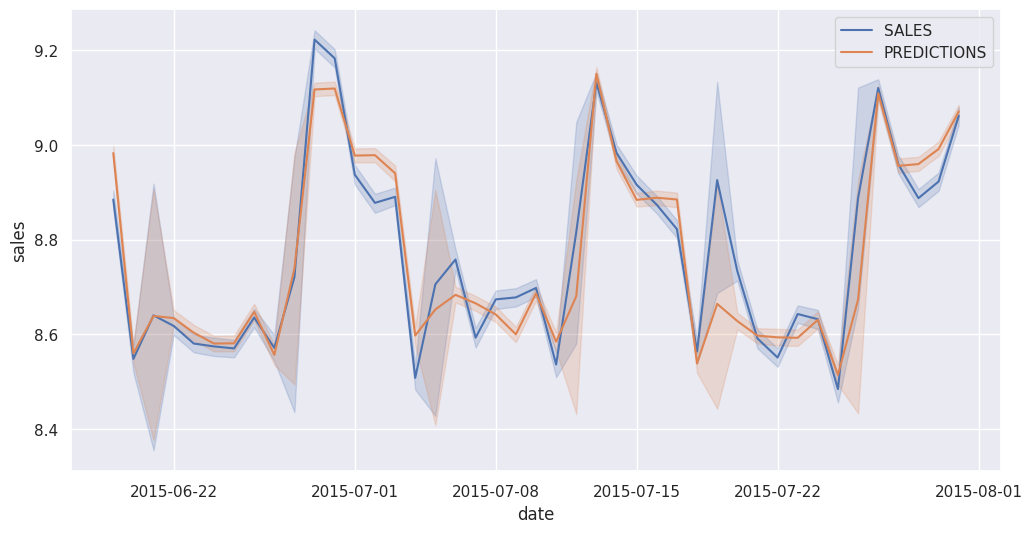

In [95]:
# gráfico predição
sns.lineplot(x='date', y='sales', data=df_sales_predict_xgb, label='SALES')
sns.lineplot(x='date', y='preticted_sales', data=df_sales_predict_xgb, label='PREDICTIONS')

## 7.5 Comparativo das Performances dos Modelos

In [121]:
# Performance simples
modelling_result = pd.concat([baseline_result, lr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,868.958204,0.130309,1238.550842
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215


In [228]:
# Performance - cross-validation
modelling_result_cv = pd.concat([lr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAR CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,974.05 +/- 161.1,0.14 +/- 0.02,1387.0 +/- 224.92
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


# 8.0 PASSO 08 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [122]:
# positivo (sub estimando) - valor predito tende a ser menor que o valor real
# negativo (super estimando) - valor predito tende a ser maior que o valor real
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_rf))
mpe

-0.019160106033745315

In [171]:
df9 = X_test[cols_selected_boruta_full].copy()

# reescala
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_rf)

## 8.1 Performance do modelo de Machine Learning

In [180]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot: xlabel='predictions', ylabel='error'>

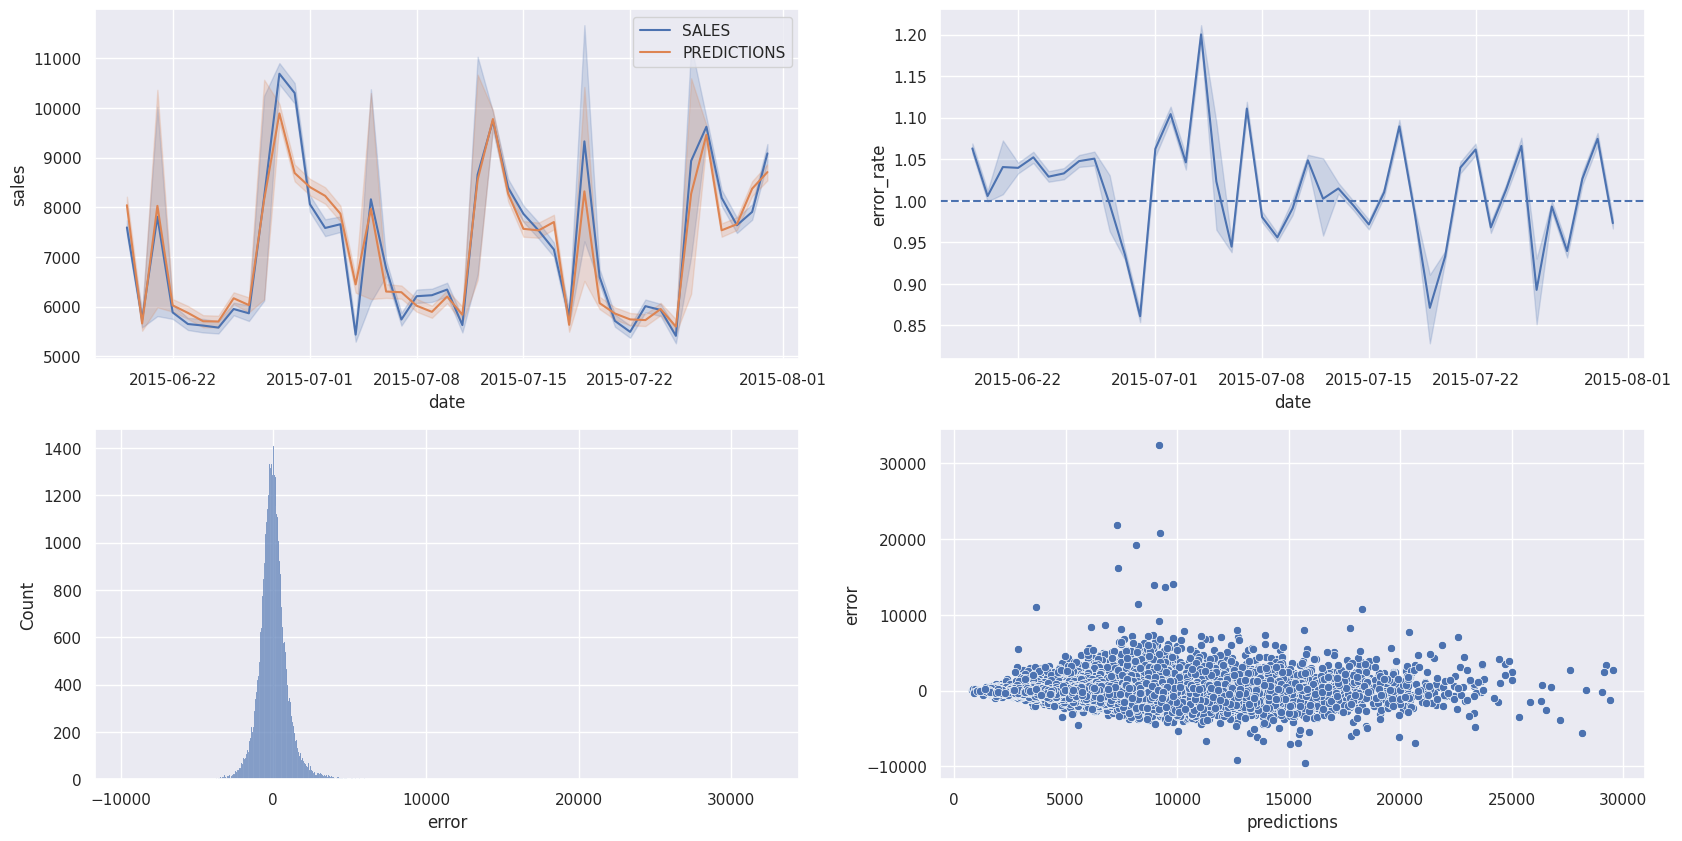

In [229]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

# análise de sub e super estimativa
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

# distribuição do erro
plt.subplot(2, 2, 3)
sns.histplot(df9['error'])

# resíduo
plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

## 8.2 Performance para o Negócio

In [209]:
# soma das predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# melhor e pior cenários
df92['worst_scenarios'] = df92['predictions'] - df92['MAE']
df92['best_scenarios'] = df92['predictions'] + df92['MAE']

# ordem das colunas
df92 = df92[['store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']]

In [208]:
# lojas mais desafiadoras
df92.sort_values('MAPE', ascending=True).head(10)

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
561,562,732881.248347,732064.932013,733697.564681,816.316334,0.046317
816,817,776654.126627,775741.792476,777566.460779,912.334151,0.047465
206,207,402381.621620,401779.394629,402983.848611,602.226991,0.048268
115,116,264874.838226,264538.837986,265210.838467,336.000241,0.049606
598,599,360865.330398,360365.623621,361365.037174,499.706776,0.051065
1074,1075,422570.359810,421959.091845,423181.627775,611.267965,0.052727
258,259,560666.858078,559972.361386,561361.354770,694.496692,0.053950
497,498,261919.437620,261526.510433,262312.364807,392.927187,0.054086
582,583,156787.987808,156573.145488,157002.830127,214.842320,0.054318
290,291,285974.999534,285522.970338,286427.028731,452.029196,0.055838


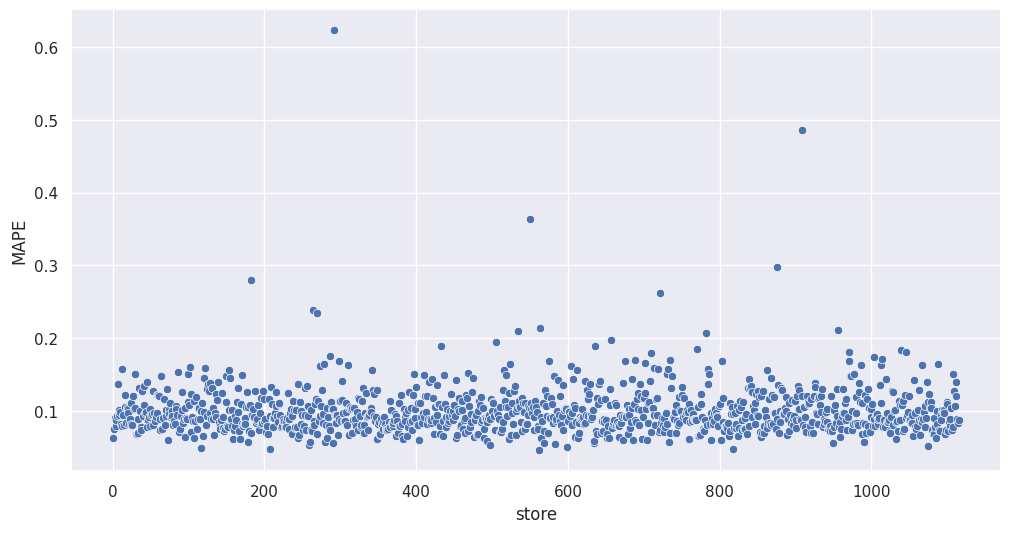

In [210]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 8.3 Performance Total

In [179]:
df93 = df92[['predictions', 'worst_scenarios', 'best_scenarios']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('€ {:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"€ 289,356,181.44"
1,worst_scenarios,"€ 288,595,370.01"
2,best_scenarios,"€ 290,116,992.86"
